# Compute neoclassical theory with only $N_c q$, $\delta$, $\varepsilon$ and $\nu_\star$

## <font color='red'>Import modules, loading datas, defining basic functions</font>

In [1]:
import ipywidgets as widgets
%matplotlib widget

import numpy as np
import matplotlib.pyplot as plt
from scipy import special
import scipy.integrate as integrate
from scipy.misc import derivative
import h5py as h5
import pickle
import time
from scipy.interpolate import InterpolatedUnivariateSpline
import glob

plt.close('all')
plt.rcParams['axes.formatter.limits'] = (-2,2)
plt.rc('font',size=14)
plt.rcParams.update({"axes.grid" : True})

import matplotlib.colors as mcol
import matplotlib.cm as cm

#Define custom colormap
cm1 = mcol.LinearSegmentedColormap.from_list("MyCmapName",["b","r"])

#Defining array from 0 to 2pi for poloidal averaging
res = 300
axe_theta = np.linspace(0,2*np.pi,res)

# %% Définition des paramètres
N             = 16
Eps           = 3.2
inv_rho_star  = 150
a             = inv_rho_star

## <font color='red'>Defining collisional functions</font>

In [4]:
# %% Collisions related functions
def Phi_v(v)   : return (2/(np.sqrt(np.pi))) * integrate.quad(lambda x: np.exp(-x**2),0,v)[0]
def G_v(v)     : return 1/(2*v**2) * (Phi_v(v) - v * derivative(Phi_v,v,dx=1e-3))
def nu_bar_v(v): return 0.75*np.sqrt(2*np.pi) * v**(-3) * (Phi_v(v) - G_v(v))
def nu_bar_u(u): return nu_bar_v(np.sqrt(u))

# %% Regime discrimination functions
def min_ap(x,y): return x*y/(x+y)
#def min_ap(x,y): return np.min([x,y])
def max_ap(x,y): return x+y

# <ins><font color='coral'>Transport coefficients with the $d_{NN}, d_{NV}, ...$ notation</font></ins>

In [6]:
I=(4 * 1.38 / np.pi)
sp2 = np.sqrt(np.pi/2)

res = 300
axe_theta = np.linspace(0,2*np.pi,res)
ulim=20

def kT_kE_kP(DoE, nustar, Nq):

    G0, G0_prime, G0_second, G1 = 0, 0, 0, 0
    for th in axe_theta:
        Y = 2
        if DoE > 1e-7: Y = np.abs(np.sin(th))/(DoE*Nq) #Sécurité pour delta-->0
        if Y >= 1:
            #G0         += DoE**2/res
            G0         += 0
        if Y < 1:
            DoE_eff = DoE * ( np.sqrt(   1 - Y**2    ) - Y * np.arccos(Y) ) 
            G0_prime   += DoE_eff**2/res
            G0_second  += DoE**(0.5)/res
            G1         += 2 * DoE_eff**(1.5) * np.sin(th)**2 /res
    
    int_u2_torI        = integrate.quad( lambda u : np.exp(-u) * u**2 * min_ap( 1, I * nustar*nu_bar_u(u)/np.sqrt(u)), 0,ulim)[0]
    int_u52_torII      = integrate.quad( lambda u : np.exp(-u) * u**(5/2) / nu_bar_u(u), 0,ulim)[0] 
    int_u2_ripI        = integrate.quad( lambda u : np.exp(-u) * u**2 * (G0 + min_ap( G0_prime, G0_second*I*nustar/(Nq)*nu_bar_u(u)/np.sqrt(u))), 0,ulim)[0]
    int_u52_ripII      = integrate.quad( lambda u : np.exp(-u) * u**(5/2) / nu_bar_u(u) * (1+(np.pi**2 / 8) * nustar*(Nq)**2*nu_bar_u(u)/np.sqrt(u)), 0,ulim )[0]
    
    int_u2_torI_u15    = integrate.quad( lambda u : np.exp(-u) * u**2 * min_ap( 1, I * nustar*nu_bar_u(u)/np.sqrt(u)) * (u-1.5), 0,ulim)[0] 
    int_u52_torII_u15  = integrate.quad( lambda u : np.exp(-u) * (u**(5/2) / nu_bar_u(u)) * (u-1.5), 0,ulim)[0]
    int_u52_ripII_u15  = integrate.quad( lambda u : np.exp(-u) * (u**(5/2) / nu_bar_u(u)) * (1+(np.pi**2 / 8) * nustar*(Nq)**2*nu_bar_u(u)/np.sqrt(u)) * (u-1.5), 0,ulim)[0]

    
    d_NN = (2/np.pi)**(1.5)* (1/nustar) * ( (32/9) * G1 * int_u52_torII + (2/(Nq)) * DoE**2 * int_u52_ripII  ) + sp2 * int_u2_torI
    d_VV = sp2 * ( Nq *int_u2_ripI + int_u2_torI)
    d_NV = sp2 * int_u2_torI
    d_NT = (2/np.pi)**(1.5) * (1/nustar) * ( (32/9) * G1 * int_u52_torII_u15 + 2 * (1/(Nq)) * DoE**2 * int_u52_ripII_u15 ) + sp2 * int_u2_torI_u15
    d_VT = np.sqrt(np.pi/2) * int_u2_torI_u15
    
    Delta_inv = 1/(d_NN*d_VV - d_NV**2)
    kT = Delta_inv * ( d_NV * d_NT - d_NN * d_VT )
    kE = Delta_inv * ( d_VV * d_NT - d_NV * d_VT )
    kP = 1 + kT - kE
    
    return kT, kE, kP, G0, G0_prime, G0_second, G1

def kT_kE_kP_mod(DoE, nustar, Nq):

    G0, G0_prime, G0_second, G1 = 0, 0, 0, 0
    for th in axe_theta:
        Y = 2
        if DoE > 1e-7: Y = np.abs(np.sin(th))/(DoE*Nq) #Sécurité pour delta-->0
        if Y >= 1:
#             G0         += DoE**2/res
            G0         += 0
        if Y < 1:
            DoE_eff = DoE * ( np.sqrt(   1 - Y**2    ) - Y * np.arccos(Y) ) 
            G0_prime   += DoE_eff**2/res
            G0_second  += DoE**(0.5)/res
            G1         += 2 * DoE_eff**(1.5) * np.sin(th)**2 /res
    
    int_u2_torI        = integrate.quad( lambda u : np.exp(-u) * u**2 * min_ap( 1, I * nustar*nu_bar_u(u)/np.sqrt(u)), 0,ulim)[0]
    int_u52_torII      = integrate.quad( lambda u : np.exp(-u) * u**(5/2) / nu_bar_u(u), 0,ulim)[0] 
    int_u2_ripI        = integrate.quad( lambda u : np.exp(-u) * u**2 * (min_ap( G0 +G0_prime, G0 + G0_second*I*nustar/(Nq)*nu_bar_u(u)/np.sqrt(u))), 0,ulim)[0]
    int_u52_ripII      = integrate.quad( lambda u : np.exp(-u) * u**(5/2) / nu_bar_u(u) * (1+(np.pi**2 / 8) * nustar*(Nq)**2*nu_bar_u(u)/np.sqrt(u)), 0,ulim )[0]
    
    int_u2_torI_u15    = integrate.quad( lambda u : np.exp(-u) * u**2 * min_ap( 1, I * nustar*nu_bar_u(u)/np.sqrt(u)) * (u-1.5), 0,ulim)[0] 
    int_u52_torII_u15  = integrate.quad( lambda u : np.exp(-u) * (u**(5/2) / nu_bar_u(u)) * (u-1.5), 0,ulim)[0]
    int_u52_ripII_u15  = integrate.quad( lambda u : np.exp(-u) * (u**(5/2) / nu_bar_u(u)) * (1+(np.pi**2 / 8) * nustar*(Nq)**2*nu_bar_u(u)/np.sqrt(u)) * (u-1.5), 0,ulim)[0]

    
    d_NN = (2/np.pi)**(1.5)* (1/nustar) * ( (32/9) * G1 * int_u52_torII + (2/(Nq)) * DoE**2 * int_u52_ripII  ) + sp2 * int_u2_torI
    d_VV = sp2 * ( Nq * int_u2_ripI + int_u2_torI)
    d_NV = sp2 * int_u2_torI
    d_NT = (2/np.pi)**(1.5) * (1/nustar) * ( (32/9) * G1 * int_u52_torII_u15 + 2 * (1/(Nq)) * DoE**2 * int_u52_ripII_u15 ) + sp2 * int_u2_torI_u15
    d_VT = np.sqrt(np.pi/2) * int_u2_torI_u15
    
    Delta_inv = 1/(d_NN*d_VV - d_NV**2)
    kT = Delta_inv * ( d_NV * d_NT - d_NN * d_VT )
    kE = Delta_inv * ( d_VV * d_NT - d_NV * d_VT )
    kP = 1 + kT - kE
    
    return kT, kE, kP, G0, G0_prime, G0_second, G1

## <font color='coral'>Scan $\delta/\varepsilon$ - $k_T$, $k_E$, $k_P$ et facteurs de forme</font>

In [4]:
DoE_ar    = np.logspace(-2, 0, 70)
nustar_ar = [0.05, 0.1, 0.25, 0.5]
Nq        = 16 * 1.4

color_ar = ['r','g','b','darkorange','purple']

fig = plt.figure(figsize=(12,12))
ax_kT = fig.add_subplot(311); ax_kT.set_title(r'$k_T$')
ax_kE = fig.add_subplot(312); ax_kE.set_title(r'$k_E$')
ax_kP = fig.add_subplot(313); ax_kP.set_title(r'$k_P$')

fig2 = plt.figure(figsize=(12,6))
ax_G = fig2.add_subplot(111)

for inu,nustar in enumerate(nustar_ar):
    kT_ar,kE_ar,kP_ar = (np.array([]) for i in range(3) )
    kT_ar_mod,kE_ar_mod,kP_ar_mod = (np.array([]) for i in range(3) )
    for iDoE,DoE in enumerate(DoE_ar):
        kT,kE,kP,G0,G0_prime,G0_second,G1 = kT_kE_kP(DoE, nustar, Nq)
        kT_ar  = np.append(kT_ar, kT)
        kE_ar  = np.append(kE_ar, kE)      
        kP_ar  = np.append(kP_ar, kP)
        
        kT_mod,kE_mod,kP_mod,_,_,_,_ = kT_kE_kP_mod(DoE, nustar, Nq)
        kT_ar_mod  = np.append(kT_ar_mod, kT_mod)
        kE_ar_mod  = np.append(kE_ar_mod, kE_mod)      
        kP_ar_mod  = np.append(kP_ar_mod, kP_mod)
        

        if inu==0:
            ax_G.loglog(DoE, G0, marker='o', ls='',c='r', label=r'$G_0$')
            ax_G.loglog(DoE, G0_prime, marker='o', ls='', c='g', label=r'$G_0^{\prime}$')
            ax_G.loglog(DoE, G0_second, marker='o', ls='', c='b', label=r'$G_0^{\prime\prime}$')
            ax_G.loglog(DoE, G1, marker='o', ls='', c='darkorange', label=r'$G_1$')
        
    ax_kT.semilogx(DoE_ar, kT_ar,color=color_ar[inu], label=r'$\nu_\star = %s$' % nustar)
    ax_kE.semilogx(DoE_ar, kE_ar,color=color_ar[inu], label=r'$\nu_\star = %s$' % nustar)
    ax_kP.semilogx(DoE_ar, kP_ar,color=color_ar[inu], label=r'$\nu_\star = %s$' % nustar)
    
    ax_kT.semilogx(DoE_ar, kT_ar_mod,color=color_ar[inu], ls='--', label=r'$\nu_\star = %s$' % nustar)
    ax_kE.semilogx(DoE_ar, kE_ar_mod,color=color_ar[inu], ls='--', label=r'$\nu_\star = %s$' % nustar)
    ax_kP.semilogx(DoE_ar, kP_ar_mod,color=color_ar[inu], ls='--', label=r'$\nu_\star = %s$' % nustar)
        
for axes in [ax_kT,ax_kE,ax_kP,ax_G]:
    handles, labels = axes.get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    axes.legend(by_label.values(), by_label.keys(),ncol=2)
    
    axes.axhline(y=0,c='k',ls='--')
    
    axes.set_xlabel(r'$\delta/\varepsilon$',fontsize=20)
    axes.axvline(x=0.032,c='k')
    axes.axvline(x=0.064,c='k')
    axes.axvline(x=0.19,c='k')
    
ax_kP.axhline(y=1.17,c='k')

fig.tight_layout()

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

### <font color='coral'>Generate data for benchmark comparison</font>

In [44]:
DoE_ar    = np.logspace(-2, 0, 30)
nustar_ar = [0.05, 0.1, 0.25, 0.5]
Nq        = 16 * 1.4


kT_th = {'nustar_005':{},'nustar_01':{}, 'nustar_025':{}, 'nustar_05':{}}
kT_th['DoE'] = DoE_ar

for inu,nustar in enumerate(nustar_ar):
    kT_ar,kE_ar,kP_ar = (np.array([]) for i in range(3))
    for iDoE,DoE in enumerate(DoE_ar):
        kT,kE,kP,G0,G0_prime,G0_second,G1 = kT_kE_kP(DoE, nustar, Nq)
        kT_ar  = np.append(kT_ar, kT)
        kE_ar  = np.append(kE_ar, kE)      
        kP_ar  = np.append(kP_ar, kP)

    if inu == 0: 
        kT_th['nustar_005']['kT_theory'] = kT_ar
        kT_th['nustar_005']['kE_theory'] = kE_ar
        kT_th['nustar_005']['kP_theory'] = kP_ar
        
    if inu == 1: 
        kT_th['nustar_01']['kT_theory'] = kT_ar
        kT_th['nustar_01']['kE_theory'] = kE_ar
        kT_th['nustar_01']['kP_theory'] = kP_ar

    if inu == 2: 
        kT_th['nustar_025']['kT_theory'] = kT_ar
        kT_th['nustar_025']['kE_theory'] = kE_ar
        kT_th['nustar_025']['kP_theory'] = kP_ar
        
    if inu == 3: 
        kT_th['nustar_05']['kT_theory'] = kT_ar
        kT_th['nustar_05']['kE_theory'] = kE_ar
        kT_th['nustar_05']['kP_theory'] = kP_ar
        
import pickle

kT_th_file = open("data_comparison/kT_theory_deltascan.pkl","wb")
pickle.dump(kT_th,kT_th_file)
kT_th_file.close()

## <font color='coral'>Scan $\nu_\star$ - $k_T$, $k_E$, $k_P$</font>

In [39]:
nustar_ar = np.logspace(-3, 0, 10)
DoE_ar    = np.array([0.001, 0.005, 0.01, 0.03, 0.06]) *3.2
#DoE_ar    = np.logspace(-3, -1, 4) * (3.2)
Nq        = 18 * 3

color_ar = ['r','g','b','darkorange','purple','coral']

fig = plt.figure(figsize=(12,8))
ax_kT = fig.add_subplot(311); ax_kT.set_ylabel(r'$k_T$')
ax_kE = fig.add_subplot(312); ax_kE.set_ylabel(r'$k_E$')
ax_kP = fig.add_subplot(313); ax_kP.set_ylabel(r'$k_P$')

for iDoE,DoE in enumerate(DoE_ar):
    kT_ar,kE_ar,kP_ar = (np.array([]) for i in range(3) )
    for inu,nustar in enumerate(nustar_ar):
        kT,kE,kP,G0,G0_prime,G0_second,G1 = kT_kE_kP(DoE, nustar, Nq)
        kT_ar  = np.append(kT_ar, kT)
        kE_ar  = np.append(kE_ar, kE)      
        kP_ar  = np.append(kP_ar, kP)

    ax_kT.semilogx(nustar_ar, kT_ar,color=color_ar[iDoE], label=r'$\delta =$ %.1f' % (DoE/3.2*100) + '%')
    ax_kE.semilogx(nustar_ar, kE_ar,color=color_ar[iDoE], label=r'$\delta =$ %.1f' % (DoE/3.2*100) + '%')
    ax_kP.semilogx(nustar_ar, kP_ar,color=color_ar[iDoE], label=r'$\delta =$ %.1f' % (DoE/3.2*100) + '%')
    
    ax_kP.set_xlabel(r'$\nu_\star$',fontsize=20)
    #ax.set_ylim(bottom=1e-4, top=1e4)
        
    handles, labels = ax_kT.get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    ax_kT.legend(by_label.values(), by_label.keys())

fig.tight_layout()

<ipython-input-39-d01043b2fa20>:8: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure(figsize=(12,8))


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

### <font color='coral'>Generate data for benchmark comparison</font>

In [45]:
DoE_ar    = np.array([0.005,0.01,0.03])*3.2*2
nustar_ar = np.linspace(0.01,1,40)
Nq        = 16*1.4

kT_th = {'RIPPLEG05':{},'RIPPLEG1':{}, 'RIPPLEG3':{}}
kT_th['nustar'] = nustar_ar

for iDoE,DoE in enumerate(DoE_ar):
    kT_ar,kE_ar,kP_ar = (np.array([]) for i in range(3) )
    for inu,nustar in enumerate(nustar_ar):
        kT,kE,kP,G0,G0_prime,G0_second,G1 = kT_kE_kP(DoE, nustar, Nq)
        kT_ar  = np.append(kT_ar, kT)
        kE_ar  = np.append(kE_ar, kE)      
        kP_ar  = np.append(kP_ar, kP)

    if iDoE == 0: 
        kT_th['RIPPLEG05']['kT_theory'] = kT_ar
        kT_th['RIPPLEG05']['kE_theory'] = kE_ar
        kT_th['RIPPLEG05']['kP_theory'] = kP_ar
        
    if iDoE == 1: 
        kT_th['RIPPLEG1']['kT_theory'] = kT_ar
        kT_th['RIPPLEG1']['kE_theory'] = kE_ar
        kT_th['RIPPLEG1']['kP_theory'] = kP_ar
#         np.save('data_comparison/kT_theory_RG1.npy', kT_ar)
#         np.save('data_comparison/kE_theory_RG1.npy', kE_ar)
#         np.save('data_comparison/kP_theory_RG1.npy', kP_ar)
    if iDoE == 2: 
        kT_th['RIPPLEG3']['kT_theory'] = kT_ar
        kT_th['RIPPLEG3']['kE_theory'] = kE_ar
        kT_th['RIPPLEG3']['kP_theory'] = kP_ar
        
import pickle

kT_th_file = open("data_comparison/kT_theory.pkl","wb")
pickle.dump(kT_th,kT_th_file)
kT_th_file.close()
#         np.save('data_comparison/kT_theory_RG3.npy', kT_ar)
#         np.save('data_comparison/kE_theory_RG3.npy', kE_ar)
#         np.save('data_comparison/kP_theory_RG3.npy', kP_ar)

## <font color='coral'>($\delta / \varepsilon$,$\nu_\star$) map - $k_T$, $k_E$, $k_P$</font>

### <font color='coral'>Generate data</font>

In [47]:
DoE_ar    = np.logspace(-3, 0, 100)
nustar_ar = np.logspace(-2, 0, 100)
Nq        = 18*3

color_ar = ['r','g','b','darkorange','purple']

kT_map,kE_map,kP_map = (np.zeros((len(DoE_ar),len(nustar_ar))) for i in range(3))

for iDoE,DoE in enumerate(DoE_ar):
    print('%s/%s' % (iDoE,len(DoE_ar)))
    for inu,nustar in enumerate(nustar_ar):
        kT_map[iDoE,inu],kE_map[iDoE,inu],kP_map[iDoE,inu],_,_,_,_ = kT_kE_kP(DoE, nustar, Nq)

np.save('Buffer_theory/kT_Nq%s' % Nq, kT_map)
np.save('Buffer_theory/kE_Nq%s' % Nq, kE_map)
np.save('Buffer_theory/kP_Nq%s' % Nq, kP_map)

0/100


KeyboardInterrupt: 

### <font color='coral'>Plot</font>

In [46]:
fig = plt.figure(figsize=(12,4))
ax_kT = fig.add_subplot(131); ax_kT.set_title(r'$k_T$')
ax_kE = fig.add_subplot(132); ax_kE.set_title(r'$k_E$')
ax_kP = fig.add_subplot(133); ax_kP.set_title(r'$k_P$')

### Donnée simulations
rho_TS = np.load('Experimental_data/rho_TS.npy')
eps_TS = np.load('Experimental_data/eps_TS.npy')
nustar_th_TS = np.load('Experimental_data/nustar_th_TS.npy')
ripple_TS = np.load('Experimental_data/ripple_TS.npy')

### Donnée #45494
data_45494   = np.genfromtxt('Experimental_data/nustar_prof_45494.csv', delimiter=',')
rho_45494    = data_45494.T[0]
nustar_45494 = data_45494.T[1]
nustar_interp_45494 = InterpolatedUnivariateSpline(rho_45494,nustar_45494, k=2)(rho_TS)

cmap='Spectral_r'

p1 = ax_kT.pcolormesh(DoE_ar,nustar_ar,kT_map.T,cmap=cmap,vmin=0.5,vmax=3)
p2 = ax_kE.pcolormesh(DoE_ar,nustar_ar,kE_map.T,cmap=cmap,vmin=0.8,vmax=3.37)
p3 = ax_kP.pcolormesh(DoE_ar,nustar_ar,kP_map.T,cmap=cmap,vmin=-0.5,vmax=1.17)

for p in [p1,p2,p3]: p.set_edgecolor('face')

ir_min = np.argmin(np.abs(rho_TS-0.5))
ir_max = np.argmin(np.abs(rho_TS-0.9))
ir_range=np.r_[ir_min:ir_max]

# #TS #45494
# ax_kE.plot((ripple_TS/eps_TS)[ir_range], nustar_interp_45494[ir_range],c='k')
# ax_kE.plot((ripple_TS/eps_TS)[ir_min], nustar_interp_45494[ir_min],c='k',marker='.')
# ax_kE.plot((ripple_TS/eps_TS)[ir_max], nustar_interp_45494[ir_max],c='k',marker='.')

# ax_kE.text((ripple_TS/eps_TS)[(ir_min+ir_max)//2], nustar_interp_45494[(ir_min+ir_max)//2], 
#            'TS#45494', c='k', horizontalalignment='left', verticalalignment='top')
# ax_kE.text((ripple_TS/eps_TS)[ir_min], nustar_interp_45494[ir_min], 
#            r'$\rho=%.1f$' % (rho_TS[ir_min]), c='k', horizontalalignment='left', verticalalignment='top')
# ax_kE.text((ripple_TS/eps_TS)[ir_max], nustar_interp_45494[ir_max], 
#            r'$\rho=%.1f$' % (rho_TS[ir_max]), c='k', horizontalalignment='left', verticalalignment='bottom')

fig.colorbar(p1,ax=ax_kT)
fig.colorbar(p2,ax=ax_kE)
fig.colorbar(p3,ax=ax_kP)

for axes in [ax_kT, ax_kE, ax_kP]:
    axes.set_xlabel(r'$\delta / \varepsilon$')
    axes.set_ylabel(r'$\nu_\star$')
    axes.set_xscale('log')
    axes.set_yscale('log')
    axes.axvline(x=1.8e-2, c='k', ls='--')
    axes.text(1.5e-3,3e-1,'No local\nmirrors',color='k',fontsize=12)
    axes.text(0.5e-1,3e-1,'Local\nmirrors\nexist',color='k',fontsize=12)
fig.tight_layout()

fig.savefig('kTkEkP_nustar_delta_map.pdf', format='pdf', bbox_inches='tight')

<ipython-input-46-42f212aea563>:1: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure(figsize=(12,4))


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

NameError: name 'kT_map' is not defined

# <ins><font color='green'>Dominating population</font></ins>

In [7]:
def dominant_population(DoE, nustar, Nq):
    G0, G0_prime, G0_second, G1 = 0, 0, 0, 0
    for th in axe_theta:
        Y = 2
        if DoE > 1e-7: Y = np.abs(np.sin(th))/(DoE*Nq) #Sécurité pour delta-->0
        if Y >= 1:
            #G0         += DoE**2/res
            G0         += 0
        if Y < 1:
            DoE_eff = DoE * ( np.sqrt(   1 - Y**2    ) - Y * np.arccos(Y) ) 
            G0_prime   += DoE**2/res
            G0_second  += DoE**(0.5)/res
            G1         += 2 * DoE_eff**(1.5) * np.sin(th)**2 /res
    
    #tor_I
    tor_I     = integrate.quad( lambda u : np.exp(-u) * u**2 * min_ap( 1, I * nustar*nu_bar_u(u)/np.sqrt(u)), 0,ulim)[0]
    
    #rip_I
    rip_I     = (Nq)*integrate.quad( lambda u : np.exp(-u) * u**2 * (G0 + min_ap( G0_prime, G0_second*I*nustar/(Nq)*nu_bar_u(u)/np.sqrt(u))), 0,ulim)[0]

    #tor_II
    tor_II    = (16/9) * ((2/np.pi)**2) * (G1/nustar) * integrate.quad( lambda u : np.exp(-u) * u**(5/2) / nu_bar_u(u), 0,ulim)[0] 
    
    #rip_II
    rip_II    = ((2/np.pi)**2) * ((Nq*nustar)**(-1)) * (DoE**2) * integrate.quad( lambda u : np.exp(-u) * u**(5/2) / nu_bar_u(u) * (1+(np.pi**2 / 8) * nustar*(Nq)**2*nu_bar_u(u)/np.sqrt(u)), 0,ulim )[0]
    
    return tor_I, rip_I, tor_II, rip_II

## <font color='green'>Scan $\delta/\varepsilon$ - Dominant population</font>

In [8]:
DoE_ar    = np.logspace(-3, 0, 200)
nustar_ar = [0.01,0.1,1]
Nq        = 18 * 1.4

color_ar = ['r','g','b','darkorange','purple']

fig = plt.figure(figsize=(12,4))

for inu,nustar in enumerate(nustar_ar):
    ax = fig.add_subplot(1,len(nustar_ar), inu+1)
    ax.set_title(r'$\nu_\star = %s$' % nustar)
    tor_I_ar, rip_I_ar, tor_II_ar, rip_II_ar = [], [], [], []
    for DoE in DoE_ar:
        tor_I, rip_I, tor_II, rip_II = dominant_population(DoE, nustar, Nq)
        tor_I_ar  = np.append(tor_I_ar, tor_I)
        rip_I_ar  = np.append(rip_I_ar, rip_I)
        tor_II_ar = np.append(tor_II_ar, tor_II)
        rip_II_ar = np.append(rip_II_ar, rip_II)

    ax.loglog(DoE_ar, tor_I_ar,  color='r', label=r'$W_{tor,I}$')
    ax.loglog(DoE_ar, rip_I_ar,  color='g', label=r'$W_{rip,I}$')
    ax.loglog(DoE_ar, tor_II_ar, color='b', label=r'$W_{tor,II}$')
    ax.loglog(DoE_ar, rip_II_ar, color='purple', label=r'$W_{rip,II}$')

    ax.set_xlabel(r'$\delta/\varepsilon$',fontsize=20)
    ax.set_ylim(bottom=1e-3, top=1e3)
        
    handles, labels = ax.get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    ax.legend(by_label.values(), by_label.keys(),fontsize=12)

fig.tight_layout()
#fig.savefig('weight_delta_scan.pdf', format='pdf', bbox_inches='tight')

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

## <font color='green'>Scan $\nu_\star$ - Dominant population</font>

In [73]:
nustar_ar = np.logspace(-3, 0, 10)
DoE_ar    = np.array([0.001, 0.01, 0.03, 0.06]) / (1/(3.2*2))
Nq        = 22

color_ar = ['r','g','b','darkorange','purple']

fig = plt.figure(figsize=(12,6))

for iDoE,DoE in enumerate(DoE_ar):
    ax = fig.add_subplot(1,len(DoE_ar), iDoE+1)
    ax.set_title(r'$\delta/\varepsilon = %.2e$' % DoE)
    tor_I_ar, rip_I_ar, tor_II_ar, rip_II_ar = [], [], [], []
    for inu,nustar in enumerate(nustar_ar):
        tor_I, rip_I, tor_II, rip_II = dominant_population(DoE, nustar, Nq)
        tor_I_ar  = np.append(tor_I_ar, tor_I)
        rip_I_ar  = np.append(rip_I_ar, rip_I)
        tor_II_ar = np.append(tor_II_ar, tor_II)
        rip_II_ar = np.append(rip_II_ar, rip_II)

    ax.loglog(nustar_ar, tor_I_ar,  color='r', label=r'$tor,I$')
    ax.loglog(nustar_ar, rip_I_ar,  color='g', label=r'$rip,I$')
    ax.loglog(nustar_ar, tor_II_ar, color='b', label=r'$tor,II$')
    ax.loglog(nustar_ar, rip_II_ar, color='purple', label=r'$rip,II$')

    ax.set_xlabel(r'$\nu_\star$',fontsize=20)
    ax.set_ylim(bottom=1e-4, top=1e4)
        
    handles, labels = ax.get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    ax.legend(by_label.values(), by_label.keys())

fig.tight_layout()

<ipython-input-73-c9de74ff3a18>:7: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure(figsize=(12,6))


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

## <font color='green'>($\delta / \varepsilon$,$\nu_\star$) map - Dominant population</font>

### <font color='green'>Generating data</font>

In [10]:
DoE_ar    = np.logspace(-3, 0, 100)
nustar_ar = np.logspace(-2, 0, 100)
Nq        = 18*1.4

if glob.glob('Buffer_theory/tor_I_Nq%s*'%Nq)!=[]:
    tor_I_ar = np.load('Buffer_theory/tor_I_Nq%s.npy'% Nq)
    rip_I_ar = np.load('Buffer_theory/rip_I_Nq%s.npy'% Nq)
    tor_II_ar = np.load('Buffer_theory/tor_II_Nq%s.npy'% Nq)
    rip_II_ar = np.load('Buffer_theory/rip_II_Nq%s.npy'% Nq)

else:
    tor_I_ar, rip_I_ar, tor_II_ar, rip_II_ar = (np.zeros((len(DoE_ar),len(nustar_ar))) for i in range(4))

    for iDoE,DoE in enumerate(DoE_ar):
        print('%s/%s' % (iDoE,len(DoE_ar)))
        for inu,nustar in enumerate(nustar_ar):
            tor_I_ar[iDoE,inu], rip_I_ar[iDoE,inu], tor_II_ar[iDoE,inu], rip_II_ar[iDoE,inu] = dominant_population(DoE, nustar, Nq)

    np.save('Buffer_theory/tor_I_Nq%s'  % Nq, tor_I_ar)
    np.save('Buffer_theory/rip_I_Nq%s'  % Nq, rip_I_ar)
    np.save('Buffer_theory/tor_II_Nq%s' % Nq, tor_II_ar)
    np.save('Buffer_theory/rip_II_Nq%s' % Nq, rip_II_ar)

0/100
1/100
2/100
3/100
4/100
5/100
6/100
7/100
8/100
9/100
10/100
11/100
12/100
13/100
14/100
15/100
16/100
17/100
18/100
19/100
20/100
21/100
22/100
23/100
24/100
25/100
26/100
27/100
28/100
29/100
30/100
31/100
32/100
33/100
34/100
35/100
36/100
37/100
38/100
39/100
40/100
41/100
42/100
43/100
44/100
45/100
46/100
47/100
48/100
49/100
50/100
51/100
52/100
53/100
54/100
55/100
56/100
57/100
58/100
59/100
60/100
61/100
62/100
63/100
64/100
65/100
66/100
67/100
68/100
69/100
70/100
71/100
72/100
73/100
74/100
75/100
76/100
77/100
78/100
79/100
80/100
81/100
82/100
83/100
84/100
85/100
86/100
87/100
88/100
89/100
90/100
91/100
92/100
93/100
94/100
95/100
96/100
97/100
98/100
99/100


### </font><font color='green'>Plot

In [11]:
fig = plt.figure(figsize=(8,8))
ax_torI  = fig.add_subplot(221); ax_torI.set_title(r'$W_{tor,I}$')
ax_ripI  = fig.add_subplot(222); ax_ripI.set_title(r'$W_{rip,I}$')
ax_torII = fig.add_subplot(223); ax_torII.set_title(r'$W_{tor,II}$')
ax_ripII = fig.add_subplot(224); ax_ripII.set_title(r'$W_{rip,II}$')

cmap='Spectral_r'

vmin=1e-1
vmax=1e0

log=0
if log:
    p1 = ax_torI.pcolormesh(DoE_ar,nustar_ar,tor_I_ar.T,cmap=cmap,norm=colors.LogNorm(vmin=vmin, vmax=vmax))
    p2 = ax_ripI.pcolormesh(DoE_ar,nustar_ar,rip_I_ar.T,cmap=cmap,norm=colors.LogNorm(vmin=vmin, vmax=vmax))
    p3 = ax_torII.pcolormesh(DoE_ar,nustar_ar,tor_II_ar.T,cmap=cmap,norm=colors.LogNorm(vmin=vmin, vmax=vmax))
    p4 = ax_ripII.pcolormesh(DoE_ar,nustar_ar,rip_II_ar.T,cmap=cmap,norm=colors.LogNorm(vmin=vmin, vmax=vmax))

else:
    p1 = ax_torI.pcolormesh(DoE_ar,nustar_ar,tor_I_ar.T,cmap=cmap,vmin=vmin,vmax=vmax)
    p2 = ax_ripI.pcolormesh(DoE_ar,nustar_ar,rip_I_ar.T,cmap=cmap,vmin=vmin,vmax=vmax)
    p3 = ax_torII.pcolormesh(DoE_ar,nustar_ar,tor_II_ar.T,cmap=cmap,vmin=vmin,vmax=vmax)
    p4 = ax_ripII.pcolormesh(DoE_ar,nustar_ar,rip_II_ar.T,cmap=cmap,vmin=vmin,vmax=vmax)

for p in [p1,p2,p3,p4]: p.set_edgecolor('face')

fig.colorbar(p1,ax=ax_torI)
fig.colorbar(p2,ax=ax_ripI)
fig.colorbar(p3,ax=ax_torII)
fig.colorbar(p4,ax=ax_ripII)

for axes in [ax_torI, ax_ripI, ax_torII, ax_ripII]:
    axes.set_xlabel(r'$\delta / \varepsilon$')
    axes.set_ylabel(r'$\nu_\star$')
    axes.set_xscale('log')
    axes.set_yscale('log')
#    axes.axvline(x=1.8e-2, c='k', ls='--')
#     axes.text(1.5e-3,3e-1,'No local\nmirrors',color='k',fontsize=12)
#     axes.text(0.5e-1,3e-1,'Local\nmirrors\nexist',color='k',fontsize=12)
fig.tight_layout()

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

### <font color='green'>Plot - Normalized to axisymmetric contribution</font>

In [36]:
import matplotlib.colors as colors

fig = plt.figure(figsize=(12,4))
ax_ripI  = fig.add_subplot(131); ax_ripI.set_title(r'$W_{rip,I} ~/~ W_{tor,I}$')
ax_torII = fig.add_subplot(132); ax_torII.set_title(r'$W_{tor,II} ~/~ W_{tor,I}$')
ax_ripII = fig.add_subplot(133); ax_ripII.set_title(r'$W_{rip,II} ~/~ W_{tor,I}$')

cmap='Spectral_r'

if 0:
    p2 = ax_ripI.pcolormesh(DoE_ar,nustar_ar,np.log10(rip_I_ar/tor_I_ar).T,cmap=cmap,vmin=-1,vmax=1)
    p3 = ax_torII.pcolormesh(DoE_ar,nustar_ar,np.log10(tor_II_ar/tor_I_ar).T,cmap=cmap,vmin=-1,vmax=1)
    p4 = ax_ripII.pcolormesh(DoE_ar,nustar_ar,np.log10(rip_II_ar/tor_I_ar).T,cmap=cmap,vmin=-1,vmax=1)

if 0:
    p2 = ax_ripI.pcolormesh(DoE_ar,nustar_ar,(rip_I_ar/tor_I_ar).T,cmap=cmap, norm=colors.LogNorm(vmin=1e-1, vmax=1e1))
    p3 = ax_torII.pcolormesh(DoE_ar,nustar_ar,(tor_II_ar/tor_I_ar).T,cmap=cmap, norm=colors.LogNorm(vmin=1e-1, vmax=1e1))
    p4 = ax_ripII.pcolormesh(DoE_ar,nustar_ar,(rip_II_ar/tor_I_ar).T,cmap=cmap, norm=colors.LogNorm(vmin=1e-1, vmax=1e1))
    
if 1:
    p2 = ax_ripI.pcolormesh(DoE_ar,nustar_ar, (rip_I_ar+tor_II_ar).T,cmap=cmap, norm=colors.LogNorm(vmin=1e-1, vmax=1e1))
    p3 = ax_torII.pcolormesh(DoE_ar,nustar_ar,(tor_I_ar+rip_II_ar).T,cmap=cmap, norm=colors.LogNorm(vmin=1e-1, vmax=1e1))
    p4 = ax_ripII.pcolormesh(DoE_ar,nustar_ar,(tor_II_ar/rip_II_ar).T,cmap=cmap, norm=colors.LogNorm(vmin=1e-1, vmax=1e1))

# if 1:
#     p2 = ax_ripI.pcolormesh(DoE_ar,nustar_ar,(rip_I_ar/tor_I_ar).T,cmap=cmap, vmin=1e-1, vmax=1e1)
#     p3 = ax_torII.pcolormesh(DoE_ar,nustar_ar,(tor_II_ar/tor_I_ar).T,cmap=cmap, vmin=1e-1, vmax=1e1)
#     p4 = ax_ripII.pcolormesh(DoE_ar,nustar_ar,(rip_II_ar/tor_I_ar).T,cmap=cmap, vmin=1e-1, vmax=1e1)
    
for p in [p2,p3,p4]: p.set_edgecolor('face')

fig.colorbar(p2,ax=ax_ripI)
fig.colorbar(p3,ax=ax_torII)
fig.colorbar(p4,ax=ax_ripII)

for axes in [ax_ripI, ax_torII, ax_ripII]:
    axes.set_xlabel(r'$\delta / \varepsilon$')
    axes.set_ylabel(r'$\nu_\star$')
    axes.set_xscale('log')
    axes.set_yscale('log')
#    axes.axvline(x=1.8e-2, c='k', ls='--')
#    axes.axvline(x=1.8e-2, c='k', ls='--')
#     axes.text(1.5e-3,3e-1,'No local\nmirrors',color='k',fontsize=12)
#     axes.text(0.5e-1,3e-1,'Local\nmirrors\nexist',color='k',fontsize=12)
fig.tight_layout()

fig.savefig('weight_nustar_delta_map.pdf', format='pdf', bbox_inches='tight')

<ipython-input-36-cc97bea89047>:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure(figsize=(12,4))


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

# <ins><font color='pink'>Neoclassical friction $\nu_\varphi$</font></ins>

In [3]:
I=(4 * 1.38 / np.pi)
sp2 = np.sqrt(np.pi/2)

res = 300
axe_theta = np.linspace(0,2*np.pi,res)
ulim=20

def nuphi(DoE, nustar, Nq):

    G0, G0_prime, G0_second, G1 = 0, 0, 0, 0
    for th in axe_theta:
        Y = 2
        if DoE > 1e-7: Y = np.abs(np.sin(th))/(DoE*Nq) #Sécurité pour delta-->0
        if Y >= 1:
            G0         += DoE**2/res
        if Y < 1:
            DoE_eff = DoE * ( np.sqrt(   1 - Y**2    ) - Y * np.arccos(Y) ) 
            G0_prime   += DoE**2/res
            G0_second  += DoE**(0.5)/res
            G1         += 2 * DoE_eff**(1.5) * np.sin(th)**2 /res
    
    int_u2_torI        = integrate.quad( lambda u : np.exp(-u) * u**2 * min_ap( 1, I * nustar*nu_bar_u(u)/np.sqrt(u)), 0,ulim)[0]
    int_u52_torII      = integrate.quad( lambda u : np.exp(-u) * u**(5/2) / nu_bar_u(u), 0,ulim)[0] 
    int_u2_ripI        = integrate.quad( lambda u : np.exp(-u) * u**2 * (G0 + min_ap( G0_prime, G0_second*I*nustar/(Nq)*nu_bar_u(u)/np.sqrt(u))), 0,ulim)[0]
    int_u52_ripII      = integrate.quad( lambda u : np.exp(-u) * u**(5/2) / nu_bar_u(u) * (1+(np.pi**2 / 8) * nustar*(Nq)**2*nu_bar_u(u)/np.sqrt(u)), 0,ulim )[0]
    
    d_NN = (2/np.pi)**(1.5)* (1/nustar) * ( (32/9) * G1 * int_u52_torII + (2/(Nq)) * DoE**2 * int_u52_ripII  ) + sp2 * int_u2_torI
    d_VV = sp2 * ( Nq * int_u2_ripI + int_u2_torI)
    d_NV = sp2 * int_u2_torI
    
    #With simulation data at rho=0.5
    nuphi_FB = (d_VV-d_NV) * (1/3.2)* ((1/6.4)**2/1.4) * (1/190)
    nuphi_PF = (d_VV-(d_NV**2/d_NN)) * (1/3.2)* ((1/6.4)**2/1.4) * (1/190)
    
    return nuphi_FB, nuphi_PF

def nuphi_mod(DoE, nustar, Nq):

    G0, G0_prime, G0_second, G1 = 0, 0, 0, 0
    for th in axe_theta:
        Y = 2
        if DoE > 1e-7: Y = np.abs(np.sin(th))/(DoE*Nq) #Sécurité pour delta-->0
        if Y >= 1:
            G0         += DoE**2/res
        if Y < 1:
            DoE_eff = DoE * ( np.sqrt(   1 - Y**2    ) - Y * np.arccos(Y) ) 
            G0_prime   += DoE**2/res
            G0_second  += DoE**(0.5)/res
            G1         += 2 * DoE_eff**(1.5) * np.sin(th)**2 /res
    
    int_u2_torI        = integrate.quad( lambda u : np.exp(-u) * u**2 * min_ap( 1, I * nustar*nu_bar_u(u)/np.sqrt(u)), 0,ulim)[0]
    int_u52_torII      = integrate.quad( lambda u : np.exp(-u) * u**(5/2) / nu_bar_u(u), 0,ulim)[0] 
    int_u2_ripI        = integrate.quad( lambda u : np.exp(-u) * u**2 * (min_ap( G0+G0_prime, G0+G0_second*I*nustar/(Nq)*nu_bar_u(u)/np.sqrt(u))), 0,ulim)[0]
    int_u52_ripII      = integrate.quad( lambda u : np.exp(-u) * u**(5/2) / nu_bar_u(u) * (1+(np.pi**2 / 8) * nustar*(Nq)**2*nu_bar_u(u)/np.sqrt(u)), 0,ulim )[0]
    
    d_NN = (2/np.pi)**(1.5)* (1/nustar) * ( (32/9) * G1 * int_u52_torII + (2/(Nq)) * DoE**2 * int_u52_ripII  ) + sp2 * int_u2_torI
    d_VV = sp2 * ( Nq * int_u2_ripI + int_u2_torI)
    d_NV = sp2 * int_u2_torI
    
    #With simulation data at rho=0.5
    nuphi_FB = (d_VV-d_NV) * (1/3.2)* ((1/6.4)**2/1.4) * (1/190)
    nuphi_PF = (d_VV-(d_NV**2/d_NN)) * (1/3.2)* ((1/6.4)**2/1.4) * (1/190)
    
    return nuphi_FB, nuphi_PF

## <font color='pink'> $\nu_\star$ scan of $\nu_\varphi$</font>

In [4]:
DoE_ar    = np.array([0.01,0.03]) * (3.2*2)
nustar_ar = np.logspace(-3, 0, 20)
Nq        = 16 * 1.4

color_ar = ['r','g','b','darkorange','purple']

fig = plt.figure(figsize=(12,4))

for iDoE,DoE in enumerate(DoE_ar):
    ax = fig.add_subplot(1,len(DoE_ar), iDoE+1)
    ax.set_title(r'$\delta/\varepsilon = %s$' % DoE)
    nuphi_FB_ar, nuphi_PF_ar = [], []
    nuphi_FB_ar_mod, nuphi_PF_ar_mod = [], []
    for inu,nustar in enumerate(nustar_ar):
        nuphi_FB, nuphi_PF = nuphi(DoE, nustar, Nq)
        nuphi_FB_ar  = np.append(nuphi_FB_ar, nuphi_FB)
        nuphi_PF_ar  = np.append(nuphi_PF_ar, nuphi_PF)
        
        nuphi_FB_mod, nuphi_PF_mod = nuphi_mod(DoE, nustar, Nq)
        nuphi_FB_ar_mod  = np.append(nuphi_FB_ar_mod, nuphi_FB_mod)
        nuphi_PF_ar_mod  = np.append(nuphi_PF_ar_mod, nuphi_PF_mod)

    ax.plot(nustar_ar, nuphi_FB_ar,  color='r', label=r'$\nu_\varphi^{FB}$')
    ax.plot(nustar_ar, nuphi_PF_ar,  color='g', label=r'$\nu_\varphi^{PF}$')
    
    ax.plot(nustar_ar, nuphi_FB_ar_mod,  color='r', label=r'$\nu_\varphi^{FB}$', ls='--')
    ax.plot(nustar_ar, nuphi_PF_ar_mod,  color='g', label=r'$\nu_\varphi^{PF}$', ls='--')

    ax.set_xlabel(r'$\nu_\star$',fontsize=20)
        
    ax.set_xlim(0.05,0.6)
        
    handles, labels = ax.get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    ax.legend(by_label.values(), by_label.keys(),fontsize=12)

fig.tight_layout()

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

## <font color='pink'> $\delta/\varepsilon$ scan of $\nu_\varphi$</font>

In [5]:
DoE_ar    = np.logspace(-2, 0, 100)
nustar_ar = [0.05, 0.1, 0.25, 0.5]
Nq        = 16 * 1.4

color_ar = ['r','g','b','darkorange','purple']

fig = plt.figure(figsize=(10,5))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

for inu,nustar in enumerate(nustar_ar):
    nuphi_FB_ar, nuphi_PF_ar = [], []
    nuphi_FB_ar_mod, nuphi_PF_ar_mod = [], []
    for iDoE,DoE in enumerate(DoE_ar):
        nuphi_FB, nuphi_PF = nuphi(DoE, nustar, Nq)
        nuphi_FB_ar  = np.append(nuphi_FB_ar, nuphi_FB)
        nuphi_PF_ar  = np.append(nuphi_PF_ar, nuphi_PF)
        
        nuphi_FB_mod, nuphi_PF_mod = nuphi_mod(DoE, nustar, Nq)
        nuphi_FB_ar_mod  = np.append(nuphi_FB_ar_mod, nuphi_FB_mod)
        nuphi_PF_ar_mod  = np.append(nuphi_PF_ar_mod, nuphi_PF_mod)
        
    ax1.loglog(DoE_ar, nuphi_FB_ar,color=color_ar[inu], label=r'$\nu_\star = %s$' % nustar)
    ax2.loglog(DoE_ar, nuphi_PF_ar,color=color_ar[inu], label=r'$\nu_\star = %s$' % nustar)
    
    ax1.loglog(DoE_ar, nuphi_FB_ar_mod,color=color_ar[inu], ls='--', label=r'$\nu_\star = %s$' % nustar)
    ax2.loglog(DoE_ar, nuphi_PF_ar_mod,color=color_ar[inu], ls='--', label=r'$\nu_\star = %s$' % nustar)
      
for ax in [ax1,ax2]:
    handles, labels = ax.get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    ax.legend(by_label.values(), by_label.keys(),ncol=2)

    ax.axhline(y=0,c='k',ls='--')

    ax.set_xlabel(r'$\delta/\varepsilon$',fontsize=20)
    ax.axvline(x=0.032,c='k')
    ax.axvline(x=0.064,c='k')
    ax.axvline(x=0.19,c='k')

fig.tight_layout()

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

## <font color='pink'>Generate data for benchmark comparison</font>

In [6]:
DoE_ar    = np.array([0.005,0.01,0.03]) * (3.2*2)
nustar_ar = np.logspace(-2, 0, 40)
Nq        = 16 * 1.4

nuphi_th = {'RIPPLEG05':{},'RIPPLEG1':{}, 'RIPPLEG3':{}}
nuphi_th['nustar'] = nustar_ar

for iDoE,DoE in enumerate(DoE_ar):
    nuphi_FB_ar, nuphi_PF_ar = [], []
    for inu,nustar in enumerate(nustar_ar):
        nuphi_FB, nuphi_PF = nuphi(DoE, nustar, Nq)
        nuphi_FB_ar  = np.append(nuphi_FB_ar, nuphi_FB)
        nuphi_PF_ar  = np.append(nuphi_PF_ar, nuphi_PF)
 
    if iDoE == 0: 
        nuphi_th['RIPPLEG05']['nuphi_FB'] = nuphi_FB_ar
        nuphi_th['RIPPLEG05']['nuphi_PF'] = nuphi_PF_ar
    if iDoE == 1: 
        nuphi_th['RIPPLEG1']['nuphi_FB'] = nuphi_FB_ar
        nuphi_th['RIPPLEG1']['nuphi_PF'] = nuphi_PF_ar
    if iDoE == 2: 
        nuphi_th['RIPPLEG3']['nuphi_FB'] = nuphi_FB_ar
        nuphi_th['RIPPLEG3']['nuphi_PF'] = nuphi_PF_ar
        
import pickle

nuphi_th_file = open("data_comparison/nuphi_theory.pkl","wb")
pickle.dump(nuphi_th,nuphi_th_file)
nuphi_th_file.close()

# <ins><font color='purple'>Transport coefficients and $\nu_\varphi$ with the $d_{NN}, d_{NV}, ...$ notation</font></ins>

In [2]:
I=(4 * 1.38 / np.pi)
sp2 = np.sqrt(np.pi/2)

res = 300
axe_theta = np.linspace(0,2*np.pi,res)
ulim=20

def kT_kE_kP_new(DoE, nustar, Nq):
    
    G0, G0_prime, G0_second, G1 = 0, 0, 0, 0
    for th in axe_theta:
        Y = 2
        if DoE > 1e-7: Y = np.abs(np.sin(th))/(DoE*Nq) #Sécurité pour delta-->0
        if Y >= 1:
#             G0         += DoE**2/res
            G0         +=0
        if Y < 1:
            DoE_eff = DoE * ( np.sqrt(   1 - Y**2    ) - Y * np.arccos(Y) ) 
            G0_prime   += DoE**2/res
            G0_second  += DoE**(0.5)/res
            G1         += 2 * DoE_eff**(1.5) * np.sin(th)**2 /res
    
    K_u       = 0
    K_hat_u   = 0
    K_tilde_u = 0
    
    d       = np.zeros(3)
    d_tilde = np.zeros(3)
    d_hat   = np.zeros(3)
    
    vres    = 100
    for u in np.linspace(0.01,20,vres):
        K_u       = sp2 * np.exp(-u) * u**2 * min_ap( 1, I * nustar*nu_bar_u(u)/np.sqrt(u))
        K_tilde_u = (2/np.pi)**(1.5)*(1/nustar)*np.exp(-u) * u**(5/2)/nu_bar_u(u)* (\
                        (32/9)* G1  \
                        +2*(1/(Nq))*DoE**2 * (1+(np.pi**2 / 8) * nustar*(Nq)**2*nu_bar_u(u)/np.sqrt(u)))
        K_hat_u   = sp2 * Nq * np.exp(-u) * u**2 * (G0 + min_ap( G0_prime, G0_second*I*nustar/(Nq)*nu_bar_u(u)/np.sqrt(u)))
        
        for n in range(3):
            d[n]       += (u-1.5)**n * K_u
            d_tilde[n] += (u-1.5)**n * K_tilde_u 
            d_hat[n]   += (u-1.5)**n * K_hat_u 

    Delta = (d[0] + d_tilde[0])*(d[0] + d_hat[0])-d[0]**2 
            
    k_T = (d[0] * d_tilde[1] - d[1] * d_tilde[0])  /Delta
    k_E = ((d[0] + d_hat[0])*(d[1] + d_tilde[1]) - d[0]*d[1]) /Delta
    k_P = 1 + k_T - k_E
    return k_T, k_E, k_P

def dcoef(DoE, nustar, Nq):

    G0, G0_prime, G0_second, G1 = 0, 0, 0, 0
    for th in axe_theta:
        Y = 2
        if DoE > 1e-7: Y = np.abs(np.sin(th))/(DoE*Nq) #Sécurité pour delta-->0
        if Y >= 1:
#             G0         += DoE**2/res
            G0         += 0
        if Y < 1:
            DoE_eff = DoE * ( np.sqrt(   1 - Y**2    ) - Y * np.arccos(Y) ) 
            G0_prime   += DoE**2/res
            G0_second  += DoE**(0.5)/res
            G1         += 2 * DoE_eff**(1.5) * np.sin(th)**2 /res
    
    K_u       = 0
    K_hat_u   = 0
    K_tilde_u = 0
    
    d       = np.zeros(3)
    d_tilde = np.zeros(3)
    d_hat   = np.zeros(3)
    
    vrange  = 20
    vres    = 100
    for u in np.linspace(0.001,vrange,vres):
        K_u       = sp2 * np.exp(-u) * u**2 * min_ap( 1, I * nustar*nu_bar_u(u)/np.sqrt(u))
        K_tilde_u = (2/np.pi)**(1.5)*(1/nustar)*np.exp(-u) * u**(5/2)/nu_bar_u(u)* (\
                        (32/9)* G1  \
                        +2*(1/(Nq))*DoE**2 * (1+(np.pi**2 / 8) * nustar*(Nq)**2*nu_bar_u(u)/np.sqrt(u)))
        K_hat_u   = sp2 * Nq * np.exp(-u) * u**2 * (G0 + min_ap( G0_prime, G0_second*I*nustar/(Nq)*nu_bar_u(u)/np.sqrt(u)))
        
        for n in range(3):
            d[n]       += (u-1.5)**n * K_u * (vrange/vres)
            d_tilde[n] += (u-1.5)**n * K_tilde_u * (vrange/vres)
            d_hat[n]   += (u-1.5)**n * K_hat_u * (vrange/vres)
    
    return d, d_tilde, d_hat

def form_factors(DoE, nustar, Nq):
    
    G0, G0_prime, G0_second, G1 = 0, 0, 0, 0
    for th in axe_theta:
        Y = 2
        if DoE > 1e-7: Y = np.abs(np.sin(th))/(DoE*Nq) #Sécurité pour delta-->0
        if Y >= 1:
            #G0         += DoE**2/res
            G0         +=0
        if Y < 1:
            DoE_eff = DoE * ( np.sqrt(   1 - Y**2    ) - Y * np.arccos(Y) ) 
            G0_prime   += DoE**2/res
            G0_second  += DoE**(0.5)/res
            G1         += 2 * DoE_eff**(1.5) * np.sin(th)**2 /res
    return G0, G0_prime, G0_second, G1

## <font color='purple'> ARTICLE - Scan $\delta/\varepsilon$ - $k_T$, $k_P$, $k_E$ comparison with previous method</font>

C:\Users\RV273815\AppData\Local\Temp\ipykernel_12136\1991962613.py:3: DeprecationWarning: scipy.misc.derivative is deprecated in SciPy v1.10.0; and will be completely removed in SciPy v1.12.0. You may consider using findiff: https://github.com/maroba/findiff or numdifftools: https://github.com/pbrod/numdifftools
  def G_v(v)     : return 1/(2*v**2) * (Phi_v(v) - v * derivative(Phi_v,v,dx=1e-3))


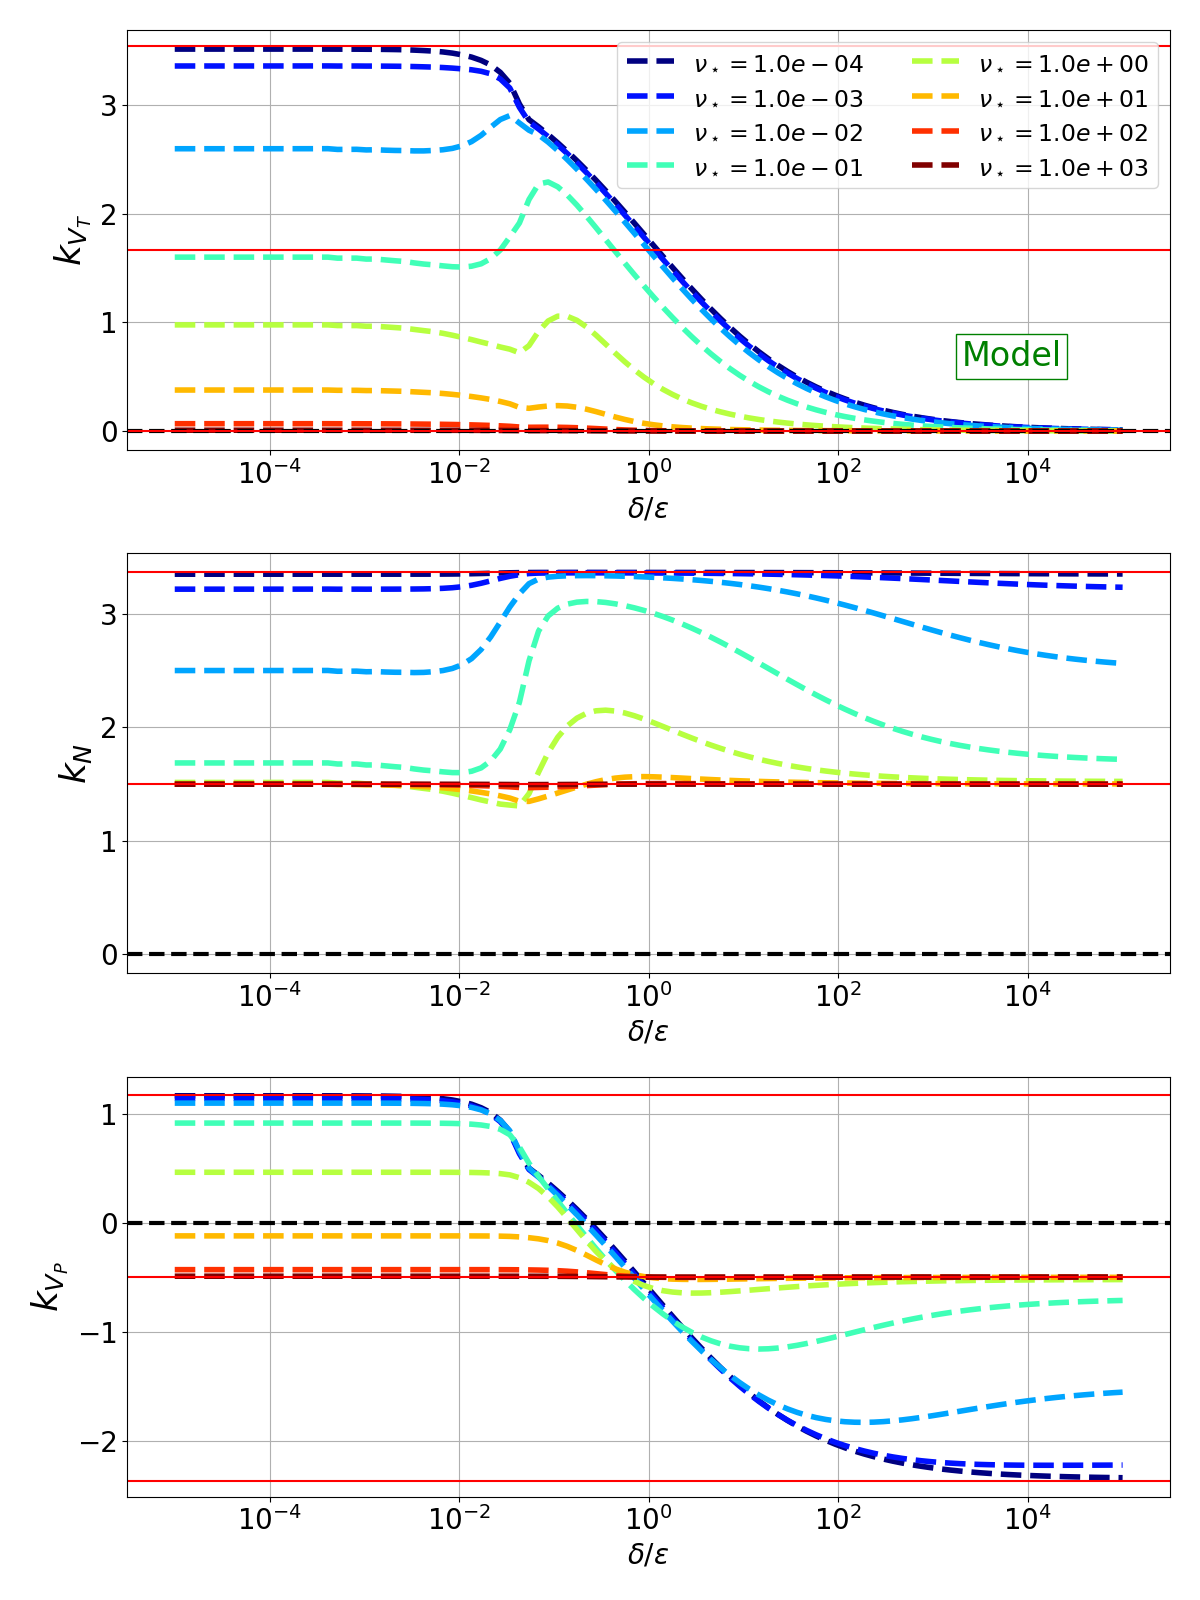

In [4]:
plt.rc('font',size=20)
DoE_ar    = np.logspace(-5, 5, 100)
nustar_ar = [1e-4,1e-3,1e-2,1e-1,1e0,1e1,1e2,1e3]
Nq        = 16 * 1.4

color_ar = ['r','g','b','darkorange','purple','steelblue','turquoise']

color_ar = plt.cm.jet(np.linspace(0,1,len(nustar_ar)))

fig = plt.figure(figsize=(12,16))
ax_kT = fig.add_subplot(311); ax_kT.set_ylabel(r'$k_{V_T}$',fontsize=26)
ax_kE = fig.add_subplot(312); ax_kE.set_ylabel(r'$k_N$',fontsize=26)
ax_kP = fig.add_subplot(313); ax_kP.set_ylabel(r'$k_{V_P}$',fontsize=26)

for inu,nustar in enumerate(nustar_ar):
    kT_ar,kE_ar,kP_ar = (np.array([]) for i in range(3) )
    kT_ar_mod,kE_ar_mod,kP_ar_mod = (np.array([]) for i in range(3) )
    for iDoE,DoE in enumerate(DoE_ar):
#         kT,kE,kP,_,_,_,_ = kT_kE_kP(DoE, nustar, Nq)
#         kT_ar  = np.append(kT_ar, kT)
#         kE_ar  = np.append(kE_ar, kE)      
#         kP_ar  = np.append(kP_ar, kP)
        
        kT_mod,kE_mod,kP_mod = kT_kE_kP_new(DoE, nustar, Nq)
        kT_ar_mod  = np.append(kT_ar_mod, kT_mod)
        kE_ar_mod  = np.append(kE_ar_mod, kE_mod)      
        kP_ar_mod  = np.append(kP_ar_mod, kP_mod)
        
#     ax_kT.semilogx(DoE_ar, kT_ar,color=color_ar[inu], label=r'$\nu_\star = %s$' % nustar)
#     ax_kE.semilogx(DoE_ar, kE_ar,color=color_ar[inu], label=r'$\nu_\star = %s$' % nustar)
#     ax_kP.semilogx(DoE_ar, kP_ar,color=color_ar[inu], label=r'$\nu_\star = %s$' % nustar)
    
    ax_kT.semilogx(DoE_ar, kT_ar_mod,color=color_ar[inu], ls='--', label=r'$\nu_\star = %.1e$' % nustar,lw=4)
    ax_kE.semilogx(DoE_ar, kE_ar_mod,color=color_ar[inu], ls='--', label=r'$\nu_\star = %.1e$' % nustar,lw=4)
    ax_kP.semilogx(DoE_ar, kP_ar_mod,color=color_ar[inu], ls='--', label=r'$\nu_\star = %.1e$' % nustar,lw=4)
        
for axes in [ax_kT]:
    handles, labels = axes.get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    axes.legend(by_label.values(), by_label.keys(),ncol=2,fontsize=17)
for axes in [ax_kT,ax_kE,ax_kP]:
    axes.axhline(y=0,c='k',ls='--',lw=3)
    
    axes.set_xlabel(r'$\delta/\varepsilon$',fontsize=20)
#     axes.axvline(x=0.032,c='k')
#     axes.axvline(x=0.064,c='k')
#     axes.axvline(x=0.19,c='k')
    
#Asymptotic regimes
ax_kT.axhline(y=1.67,c='r',ls='-')
ax_kT.axhline(y=3.54,c='r',ls='-')
ax_kT.axhline(y=0,c='r',ls='-')

ax_kE.axhline(y=1.5,c='r',ls='-')
ax_kE.axhline(y=3.37,c='r',ls='-')

ax_kP.axhline(y=1.17,c='r',ls='-')
ax_kP.axhline(y=-2.37,c='r',ls='-')
ax_kP.axhline(y=-0.5,c='r',ls='-')
    
ax_kT.text(0.8, 0.2, 'Model', color='green', 
        bbox=dict(facecolor='white', edgecolor='green'),fontsize=24,transform=ax_kT.transAxes)
    
fig.tight_layout()
fig.savefig('kTkEkP_asymptotic.pdf', format='pdf', bbox_inches='tight')

## <font color='lime'> POSTDOC </font> - Scan $Nq$ - $k_T$, $k_P$, $k_E$

C:\Users\RV273815\AppData\Local\Temp\ipykernel_15728\1991962613.py:3: DeprecationWarning: scipy.misc.derivative is deprecated in SciPy v1.10.0; and will be completely removed in SciPy v1.12.0. You may consider using findiff: https://github.com/maroba/findiff or numdifftools: https://github.com/pbrod/numdifftools
  def G_v(v)     : return 1/(2*v**2) * (Phi_v(v) - v * derivative(Phi_v,v,dx=1e-3))


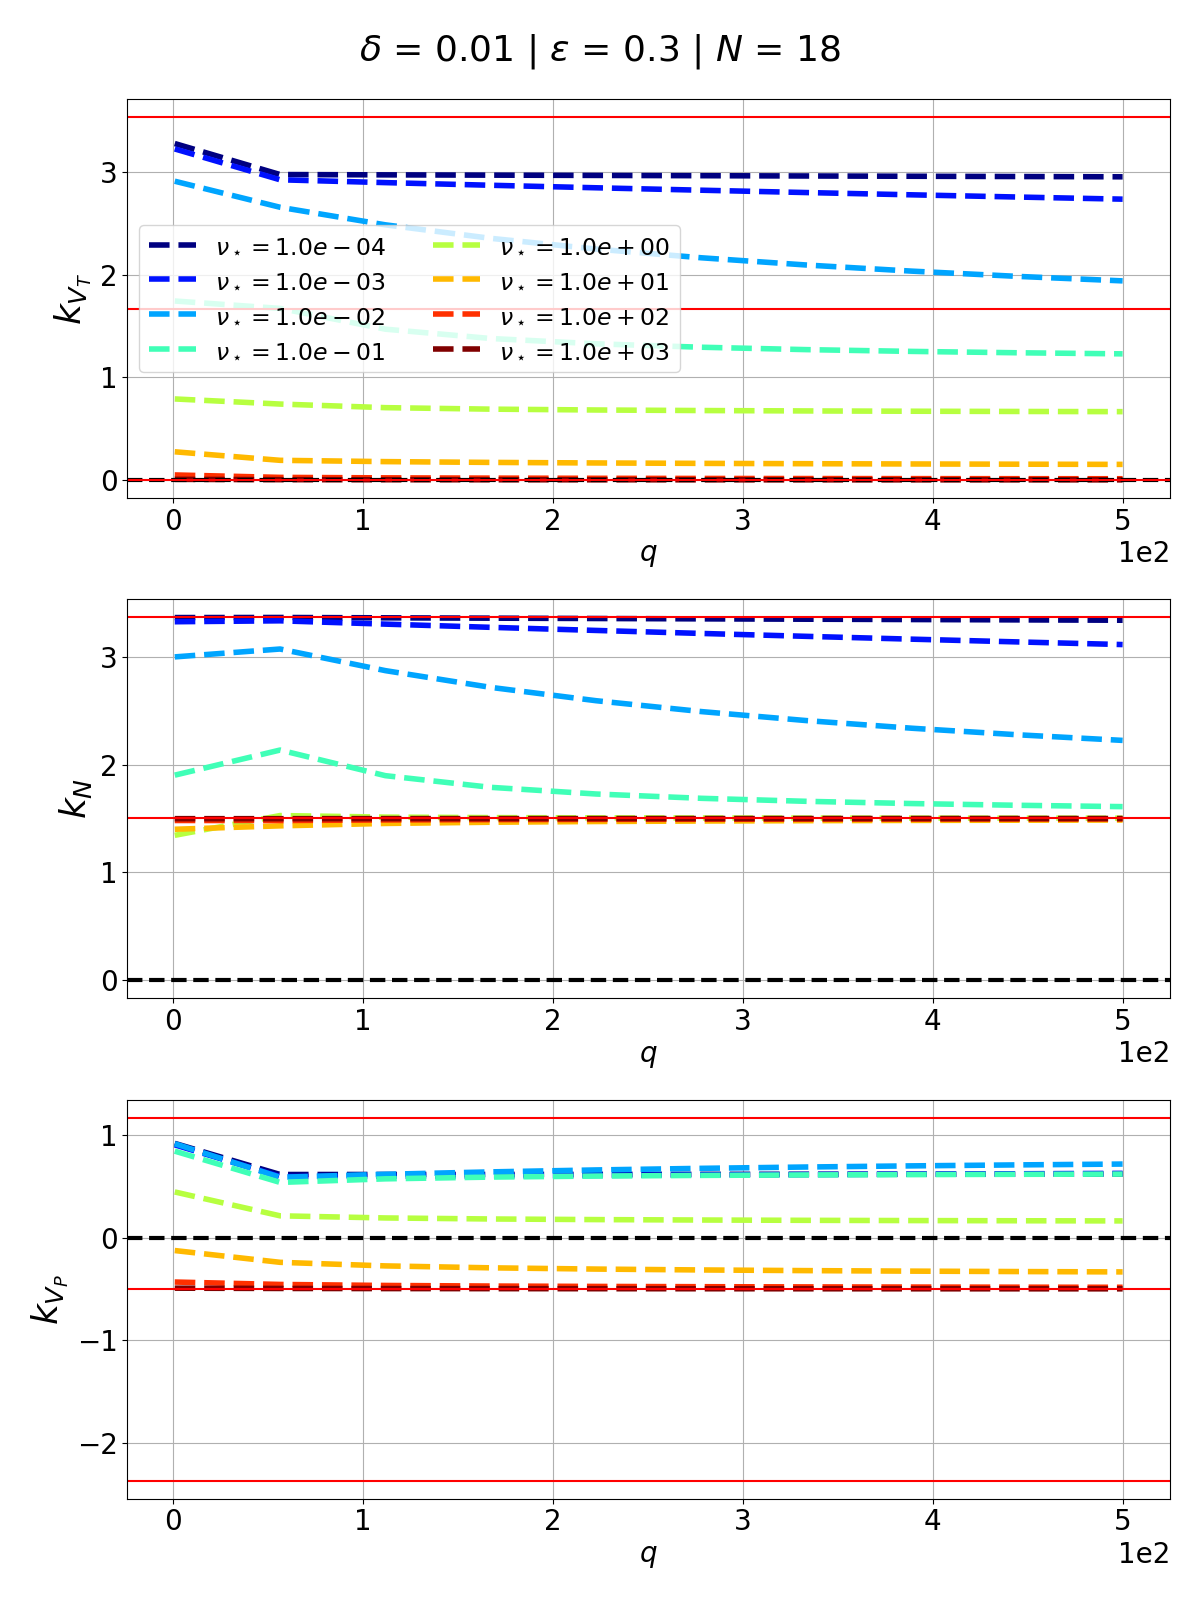

In [5]:
plt.rc('font',size=20)
delta     = 0.01
eps       = 0.3
DoE       = delta / eps
nustar_ar = [1e-4,1e-3,1e-2,1e-1,1e0,1e1,1e2,1e3]
N         = 18
Nq_ar     = N * np.linspace(1,500,10)

color_ar = ['r','g','b','darkorange','purple','steelblue','turquoise']

color_ar = plt.cm.jet(np.linspace(0,1,len(nustar_ar)))

fig = plt.figure(figsize=(12,16)); fig.suptitle(r'$\delta$ = %s | $\varepsilon$ = %s | $N$ = %s' % (delta,eps,N),fontsize=26)
ax_kT = fig.add_subplot(311); ax_kT.set_ylabel(r'$k_{V_T}$',fontsize=26)
ax_kE = fig.add_subplot(312); ax_kE.set_ylabel(r'$k_N$',fontsize=26)
ax_kP = fig.add_subplot(313); ax_kP.set_ylabel(r'$k_{V_P}$',fontsize=26)

for inu,nustar in enumerate(nustar_ar):
    kT_ar,kE_ar,kP_ar = (np.array([]) for i in range(3) )
    kT_ar_mod,kE_ar_mod,kP_ar_mod = (np.array([]) for i in range(3) )
    for iNq,Nq in enumerate(Nq_ar):     
        kT_mod,kE_mod,kP_mod = kT_kE_kP_new(DoE, nustar, Nq)
        kT_ar_mod  = np.append(kT_ar_mod, kT_mod)
        kE_ar_mod  = np.append(kE_ar_mod, kE_mod)      
        kP_ar_mod  = np.append(kP_ar_mod, kP_mod)
    
    ax_kT.plot(Nq_ar/N, kT_ar_mod,color=color_ar[inu], ls='--', label=r'$\nu_\star = %.1e$' % nustar,lw=4)
    ax_kE.plot(Nq_ar/N, kE_ar_mod,color=color_ar[inu], ls='--', label=r'$\nu_\star = %.1e$' % nustar,lw=4)
    ax_kP.plot(Nq_ar/N, kP_ar_mod,color=color_ar[inu], ls='--', label=r'$\nu_\star = %.1e$' % nustar,lw=4)
        
for axes in [ax_kT]:
    handles, labels = axes.get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    axes.legend(by_label.values(), by_label.keys(),ncol=2,fontsize=17)
for axes in [ax_kT,ax_kE,ax_kP]:
    axes.axhline(y=0,c='k',ls='--',lw=3)
    axes.set_xlabel(r'$q$',fontsize=20)
    
#Asymptotic regimes
ax_kT.axhline(y=1.67,c='r',ls='-')
ax_kT.axhline(y=3.54,c='r',ls='-')
ax_kT.axhline(y=0,c='r',ls='-')

ax_kE.axhline(y=1.5,c='r',ls='-')
ax_kE.axhline(y=3.37,c='r',ls='-')

ax_kP.axhline(y=1.17,c='r',ls='-')
ax_kP.axhline(y=-2.37,c='r',ls='-')
ax_kP.axhline(y=-0.5,c='r',ls='-')
    
fig.tight_layout()

## <font color='lime'> POSTDOC </font> - Scan $\nu^\star$ - $k_T$, $k_P$, $k_E$

C:\Users\RV273815\AppData\Local\Temp\ipykernel_15236\1991962613.py:3: DeprecationWarning: scipy.misc.derivative is deprecated in SciPy v1.10.0; and will be completely removed in SciPy v1.12.0. You may consider using findiff: https://github.com/maroba/findiff or numdifftools: https://github.com/pbrod/numdifftools
  def G_v(v)     : return 1/(2*v**2) * (Phi_v(v) - v * derivative(Phi_v,v,dx=1e-3))


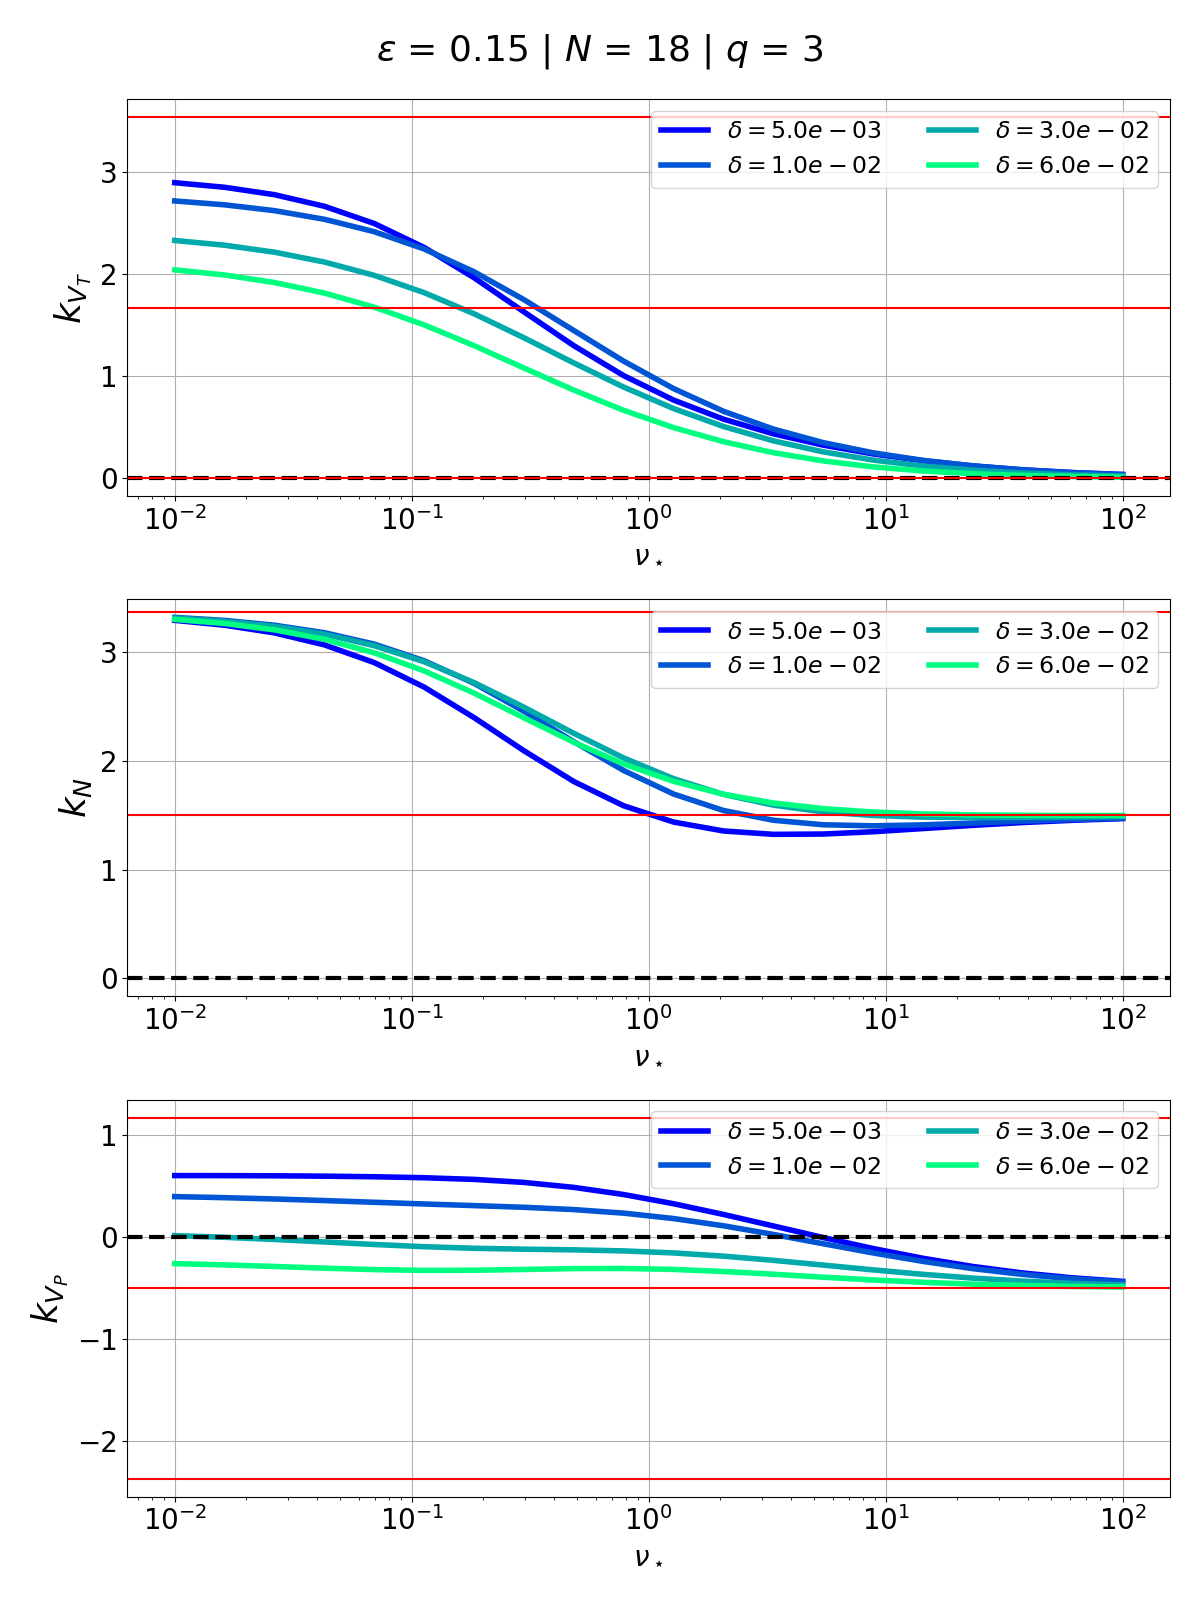

In [10]:
plt.rc('font',size=20)
delta_ar  = np.array([0.005,0.01,0.03,0.06])
eps       = 0.15
DoE_ar    = delta_ar / eps
nustar_ar = [1e-4,1e-3,1e-2,1e-1,1e0,1e1,1e2,1e3]
nustar_ar = np.logspace(-2, 2, 20)
N         = 18
q         = 3
Nq        = N * q

color_ar = ['r','g','b','darkorange','purple','steelblue','turquoise']

color_ar = plt.cm.winter(np.linspace(0,1,len(delta_ar)))

fig = plt.figure(figsize=(12,16)); fig.suptitle(r'$\varepsilon$ = %s | $N$ = %s | $q$ = %s' % (eps,N,q),fontsize=26)
ax_kT = fig.add_subplot(311); ax_kT.set_ylabel(r'$k_{V_T}$',fontsize=26)
ax_kE = fig.add_subplot(312); ax_kE.set_ylabel(r'$k_N$',fontsize=26)
ax_kP = fig.add_subplot(313); ax_kP.set_ylabel(r'$k_{V_P}$',fontsize=26)

for iDoE,DoE in enumerate(DoE_ar):     
    kT_ar,kE_ar,kP_ar = (np.array([]) for i in range(3) )
    kT_ar_mod,kE_ar_mod,kP_ar_mod = (np.array([]) for i in range(3) )
    for inu,nustar in enumerate(nustar_ar):
        kT_mod,kE_mod,kP_mod = kT_kE_kP_new(DoE, nustar, Nq)

        kT_ar_mod  = np.append(kT_ar_mod, kT_mod)
        kE_ar_mod  = np.append(kE_ar_mod, kE_mod)      
        kP_ar_mod  = np.append(kP_ar_mod, kP_mod)
    
    ax_kT.semilogx(nustar_ar, kT_ar_mod,color=color_ar[iDoE], ls='-', label=r'$\delta = %.1e$' % (DoE*eps), lw=4)
    ax_kE.semilogx(nustar_ar, kE_ar_mod,color=color_ar[iDoE], ls='-', label=r'$\delta = %.1e$' % (DoE*eps), lw=4)
    ax_kP.semilogx(nustar_ar, kP_ar_mod,color=color_ar[iDoE], ls='-', label=r'$\delta = %.1e$' % (DoE*eps), lw=4)
        
#for axes in [ax_kT]:
for axes in [ax_kT,ax_kE,ax_kP]:
    handles, labels = axes.get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    axes.legend(by_label.values(), by_label.keys(),ncol=2,fontsize=17)
for axes in [ax_kT,ax_kE,ax_kP]:
    axes.axhline(y=0,c='k',ls='--',lw=3)
    axes.set_xlabel(r'$\nu_\star$',fontsize=20)
    
#Asymptotic regimes
ax_kT.axhline(y=1.67,c='r',ls='-')
ax_kT.axhline(y=3.54,c='r',ls='-')
ax_kT.axhline(y=0,c='r',ls='-')

ax_kE.axhline(y=1.5,c='r',ls='-')
ax_kE.axhline(y=3.37,c='r',ls='-')

ax_kP.axhline(y=1.17,c='r',ls='-')
ax_kP.axhline(y=-2.37,c='r',ls='-')
ax_kP.axhline(y=-0.5,c='r',ls='-')
    
fig.tight_layout()

## <font color='lime'> POSTDOC </font> - <font color='red'> Figure pour Xavier </font> - Scan $\nu^\star$ - $k_T$, $k_P$, $k_E$

C:\Users\RV273815\AppData\Local\Temp\ipykernel_15236\1991962613.py:3: DeprecationWarning: scipy.misc.derivative is deprecated in SciPy v1.10.0; and will be completely removed in SciPy v1.12.0. You may consider using findiff: https://github.com/maroba/findiff or numdifftools: https://github.com/pbrod/numdifftools
  def G_v(v)     : return 1/(2*v**2) * (Phi_v(v) - v * derivative(Phi_v,v,dx=1e-3))


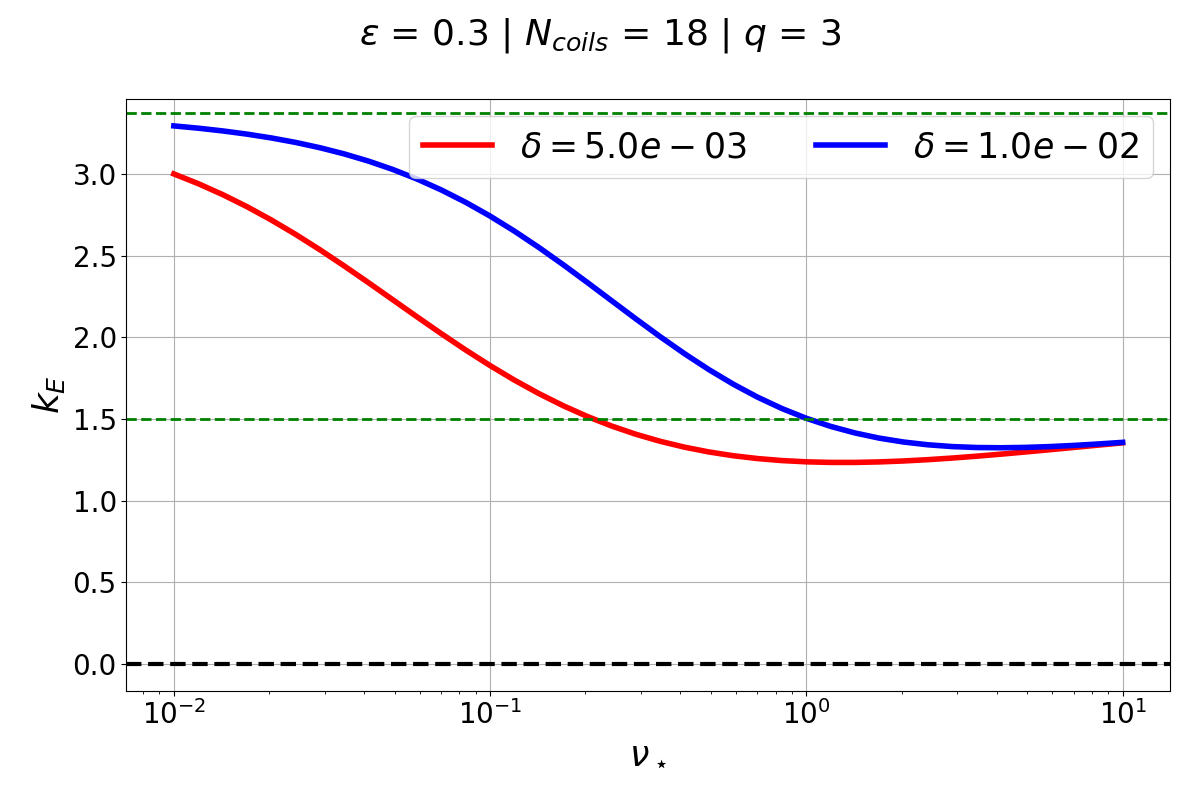

In [13]:
plt.rc('font',size=20)
delta_ar  = np.array([0.005,0.01])
eps       = 0.3
DoE_ar    = delta_ar / eps
nustar_ar = np.logspace(-2,1, 40)
N         = 18
q         = 3
Nq        = N * q

color_ar = ['r','b']

#color_ar = plt.cm.winter(np.linspace(0,1,len(delta_ar)))

fig = plt.figure(figsize=(12,8)); fig.suptitle(r'$\varepsilon$ = %s | $N_{coils}$ = %s | $q$ = %s' % (eps,N,q),fontsize=26)

ax_kE = fig.add_subplot(111); ax_kE.set_ylabel(r'$k_E$',fontsize=26)


for iDoE,DoE in enumerate(DoE_ar):     
    kT_ar,kE_ar,kP_ar = (np.array([]) for i in range(3) )
    kT_ar_mod,kE_ar_mod,kP_ar_mod = (np.array([]) for i in range(3) )
    for inu,nustar in enumerate(nustar_ar):
        kT_mod,kE_mod,kP_mod = kT_kE_kP_new(DoE, nustar, Nq)

        kT_ar_mod  = np.append(kT_ar_mod, kT_mod)
        kE_ar_mod  = np.append(kE_ar_mod, kE_mod)      
        kP_ar_mod  = np.append(kP_ar_mod, kP_mod)
    

    ax_kE.semilogx(nustar_ar, kE_ar_mod,color=color_ar[iDoE], ls='-', label=r'$\delta = %.1e$' % (DoE*eps), lw=4)

        
#for axes in [ax_kT]:
for axes in [ax_kE]:
    handles, labels = axes.get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    axes.legend(by_label.values(), by_label.keys(),ncol=2,fontsize=25)
for axes in [ax_kE]:
    axes.axhline(y=0,c='k',ls='--',lw=3)
    axes.set_xlabel(r'$\nu_\star$',fontsize=25)
    
#Asymptotic regimes
ax_kE.axhline(y=1.5,c='g',ls='--',lw=2)
ax_kE.axhline(y=3.37,c='g',ls='--',lw=2)


    
fig.tight_layout()

## <font color='purple'>Scan $\delta/\varepsilon$ - $\nu_\varphi$ comparison with previous method</font>

In [9]:
DoE_ar    = np.array([0.005,0.01,0.03]) * (3.2*2)
nustar_ar = np.logspace(-3, 0, 20)/1.5
Nq        = 16 * 1.4

color_ar = ['r','g','b','darkorange','purple']

fig = plt.figure(figsize=(12,4))

d_ar       = np.zeros((3,len(DoE_ar),len(nustar_ar)))
d_tilde_ar = np.zeros((3,len(DoE_ar),len(nustar_ar)))
d_hat_ar   = np.zeros((3,len(DoE_ar),len(nustar_ar)))

nuphi_PF_ar = np.zeros((len(DoE_ar),len(nustar_ar)))
nuphi_FB_ar = np.zeros((len(DoE_ar),len(nustar_ar)))

#Données GYSELA
nustar_GYS_005 = pickle.load(open('processed_data/nustar_GYS_005.pkl','rb'))
nustar_GYS_01  = pickle.load(open('processed_data/nustar_GYS_01.pkl','rb'))
nustar_GYS_025 = pickle.load(open('processed_data/nustar_GYS_025.pkl','rb'))
nustar_GYS_05  = pickle.load(open('processed_data/nustar_GYS_05.pkl','rb'))
nustar_GYS     = [nustar_GYS_005,nustar_GYS_01,nustar_GYS_025,nustar_GYS_05]

for iDoE,DoE in enumerate(DoE_ar):
    ax = fig.add_subplot(1,len(DoE_ar), iDoE+1)
    ax.set_title(r'$\delta/\varepsilon = %s$' % DoE)
    
    for inu,nustar in enumerate(nustar_ar):
        d_ar[:,iDoE,inu],d_tilde_ar[:,iDoE,inu],d_hat_ar[:,iDoE,inu] = dcoef(DoE, nustar, Nq)
#         nuphi_FB_ar[iDoE,inu],nuphi_PF_ar[iDoE,inu] = nuphi(DoE, nustar, Nq)

    #Parameters for comparison with GYSELA
    A = (1/3.2)* ((1/6.4)**2/1.4) * (1/190)
        
    #Previous method
#     ax.plot(nustar_ar, nuphi_PF_ar[iDoE,:], label=r'$\nu_\varphi^{PF}$',c='r',ls='--')
#     ax.plot(nustar_ar, nuphi_FB_ar[iDoE,:], label=r'$\nu_\varphi^{FB}$',c='b',ls='--')
        
    #New method
    nuphi_model, = ax.semilogy(nustar_ar, (d_hat_ar[0,iDoE,:] + (d_ar[0,iDoE,:] * d_tilde_ar[0,iDoE,:])/ (d_ar[0,iDoE,:] + d_tilde_ar[0,iDoE,:]))
            ,color='r')#, label=r'$\nu_\varphi$')# = \hat{d}_0 + \frac{d_0 \tilde{d}_0}{ d_0 + \tilde{d}_0 }$')
    ax.semilogy(nustar_ar, d_hat_ar[0,iDoE,:],  color='b', label=r'$\hat{d}_0$')
    
    ax.semilogy(nustar_ar, (d_ar[0,iDoE,:] * d_tilde_ar[0,iDoE,:])/ (d_ar[0,iDoE,:] + d_tilde_ar[0,iDoE,:])
            ,color='g', label=r'$\frac{d_0 \tilde{d}_0}{ d_0 + \tilde{d}_0 }$')

    #GYSELA
    ir = np.argmin(np.abs(nustar_GYS_05['RIPPLEG1']['rg']/150-0.5))
    for ifile,f in enumerate(nustar_GYS):
        if DoE == 0.005* (3.2*2): 
            if ifile != 0: nuphi_GYS, = ax.semilogy(f['RIPPLEG05']['mean_nustar'][ir], (A**-1)*f['RIPPLEG05']['nuphi'][ir],marker='*',markersize=25, markeredgecolor='k',markeredgewidth=1.5,c='r',ls='')
        if DoE == 0.01 * (3.2*2):ax.semilogy(f['RIPPLEG1']['mean_nustar'][ir], (A**-1)*f['RIPPLEG1']['nuphi'][ir],marker='*',markersize=25, markeredgecolor='k',markeredgewidth=1.5,c='r')
        if DoE == 0.03 * (3.2*2):ax.semilogy(f['RIPPLEG3']['mean_nustar'][ir], (A**-1)*f['RIPPLEG3']['nuphi'][ir],marker='*',markersize=25, markeredgecolor='k',markeredgewidth=1.5,c='r')
        
    ax.set_xlabel(r'$\nu_\star$',fontsize=20)
        
    ax.set_ylim(1e-3,1e0)
    #ax.set_xlim(0.05,0.6)
    if iDoE == 0:    
        handles, labels = ax.get_legend_handles_labels()
        by_label = dict(zip(labels, handles))
        leg1 = ax.legend(by_label.values(), by_label.keys(),fontsize=14,ncol=2,loc='lower right')
        leg2 = ax.legend([nuphi_model,nuphi_GYS],[r'$\nu_\varphi$ from model',r'$\nu_\varphi$ from GYSELA'], loc='upper right')
        ax.add_artist(leg1)

        #ax.set_ylabel(r'$\nu_\varphi$')
    
fig.tight_layout()
fig.savefig('benchmark_nuphi_theory_GYSELA_NEO.pdf', format='pdf', bbox_inches='tight')

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

## <font color='purple'>ARTICLE - Scan $\nu_\star$ - $\nu_\varphi$ comparison with previous method</font>

In [13]:
plt.rc('font',size=18)
DoE_ar    = np.array([0.005,0.01,0.03]) * (3.2*2)
nustar_ar = np.logspace(-3, 0, 20)/1.5
Nq        = 16 * 1.4

color_ar = ['r','g','b','darkorange','purple']

fig = plt.figure(figsize=(12,6))
fig.suptitle(r'$\varepsilon = 0.16$, $N_c=16$, $q=1.4$',y=0.88)

title_ar=[r'$\delta = 0.5$%',r'$\delta = 1.0$%',r'$\delta = 3.0$%']

d_ar       = np.zeros((3,len(DoE_ar),len(nustar_ar)))
d_tilde_ar = np.zeros((3,len(DoE_ar),len(nustar_ar)))
d_hat_ar   = np.zeros((3,len(DoE_ar),len(nustar_ar)))

nuphi_PF_ar = np.zeros((len(DoE_ar),len(nustar_ar)))
nuphi_FB_ar = np.zeros((len(DoE_ar),len(nustar_ar)))

#Données GYSELA
nustar_GYS_005 = pickle.load(open('processed_data/nustar_GYS_005.pkl','rb'))
nustar_GYS_01  = pickle.load(open('processed_data/nustar_GYS_01.pkl','rb'))
nustar_GYS_025 = pickle.load(open('processed_data/nustar_GYS_025.pkl','rb'))
nustar_GYS_05  = pickle.load(open('processed_data/nustar_GYS_05.pkl','rb'))
nustar_GYS     = [nustar_GYS_005,nustar_GYS_01,nustar_GYS_025,nustar_GYS_05]

for iDoE,DoE in enumerate(DoE_ar):
    ax = fig.add_subplot(1,len(DoE_ar), iDoE+1)
    #ax.set_title(r'$\delta/\varepsilon = %s$' % DoE)
    ax.set_title(title_ar[iDoE])
    
    for inu,nustar in enumerate(nustar_ar):
        d_ar[:,iDoE,inu],d_tilde_ar[:,iDoE,inu],d_hat_ar[:,iDoE,inu] = dcoef(DoE, nustar, Nq)
#         nuphi_FB_ar[iDoE,inu],nuphi_PF_ar[iDoE,inu] = nuphi(DoE, nustar, Nq)

    #Parameters for comparison with GYSELA
    A = (1/3.2)* ((1/6.4)**2/1.4) * (1/190)
        
    #Previous method
#     ax.plot(nustar_ar, nuphi_PF_ar[iDoE,:], label=r'$\nu_\varphi^{PF}$',c='r',ls='--')
#     ax.plot(nustar_ar, nuphi_FB_ar[iDoE,:], label=r'$\nu_\varphi^{FB}$',c='b',ls='--')
        
    #New method
    ax.semilogy(nustar_ar, (d_hat_ar[0,iDoE,:] + (d_ar[0,iDoE,:] * d_tilde_ar[0,iDoE,:])/ (d_ar[0,iDoE,:] + d_tilde_ar[0,iDoE,:]))
            ,color='g',lw=2,label=r'$\nu_\varphi^{\Gamma_{N}=0}$')
    ax.semilogy(nustar_ar, d_hat_ar[0,iDoE,:],  color='xkcd:seaweed',lw=3,ls='--',label=r'$\nu_\varphi$')

    #GYSELA
    ir = np.argmin(np.abs(nustar_GYS_05['RIPPLEG1']['rg']/150-0.5))
    for ifile,f in enumerate(nustar_GYS):
        if DoE == 0.005* (3.2*2): 
            if ifile != 0: nuphi_GYS, = ax.semilogy(f['RIPPLEG05']['mean_nustar'][ir], (A**-1)*f['RIPPLEG05']['nuphi'][ir],marker='*',markersize=25, markeredgecolor='k',markeredgewidth=1.5,c='r',ls='')
        if DoE == 0.01 * (3.2*2):ax.semilogy(f['RIPPLEG1']['mean_nustar'][ir], (A**-1)*f['RIPPLEG1']['nuphi'][ir],marker='*',markersize=25, markeredgecolor='k',markeredgewidth=1.5,c='r')
        if DoE == 0.03 * (3.2*2):ax.semilogy(f['RIPPLEG3']['mean_nustar'][ir], (A**-1)*f['RIPPLEG3']['nuphi'][ir],marker='*',markersize=25, markeredgecolor='k',markeredgewidth=1.5,c='r')
        
    ax.set_xlabel(r'$\nu_\star$',fontsize=20)
        
    ax.set_ylim(1e-3,1e0)
    #ax.set_xlim(0.05,0.6)
    if iDoE == 0:    
        handles, labels = ax.get_legend_handles_labels()
        by_label = dict(zip(labels, handles))
        leg1 = ax.legend(by_label.values(), by_label.keys(),fontsize=15,ncol=2,loc='lower right')
        leg2 = ax.legend([nuphi_GYS],[r'$\nu_\varphi$ from GYSELA'], loc='upper right',fontsize=15)
        ax.add_artist(leg1)
        ax.set_ylabel(r'$[\omega_{c0}]$')
    if iDoE == 1:
        ax.text(0.13, 0.2, 'Model', color='green', 
                    bbox=dict(facecolor='white', edgecolor='green'),fontsize=20,transform=ax.transAxes)
        ax.text(0.58, 0.2, 'GYSELA', color='red', 
                    bbox=dict(facecolor='white', edgecolor='red'),fontsize=20,transform=ax.transAxes)
        ax.text(0.47, 0.2, '&', color='k',fontsize=20,transform=ax.transAxes)

        #ax.set_ylabel(r'$\nu_\varphi$')
    
fig.tight_layout(rect=[0, 0.05, 1.0, 0.95])
fig.savefig('benchmark_nuphi_theory_GYSELA_NEO.pdf', format='pdf', bbox_inches='tight')

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

## <font color='purple'>Scan $\nu_\star$ of $d_{ii}$ coefficients </font>

In [25]:
DoE_ar    = np.array([0.005,0.01,0.03]) * (3.2*2)
nustar_ar = np.logspace(-3, 0, 30)/1.5
Nq        = 16 * 1.4

color_ar = ['r','g','b','darkorange','purple']

fig = plt.figure(figsize=(12,4))

d_ar       = np.zeros((3,len(DoE_ar),len(nustar_ar)))
d_tilde_ar = np.zeros((3,len(DoE_ar),len(nustar_ar)))
d_hat_ar   = np.zeros((3,len(DoE_ar),len(nustar_ar)))

for iDoE,DoE in enumerate(DoE_ar):
    ax = fig.add_subplot(1,len(DoE_ar), iDoE+1)
    ax.set_title(r'$\delta/\varepsilon = %s$' % DoE)
    
    for inu,nustar in enumerate(nustar_ar):
        d_ar[:,iDoE,inu],d_tilde_ar[:,iDoE,inu],d_hat_ar[:,iDoE,inu] = dcoef(DoE, nustar, Nq)
        
    #New method
    ax.loglog(nustar_ar, d_ar[0,iDoE,:],      color='b', label=r'$d_0$')
    ax.loglog(nustar_ar, d_hat_ar[0,iDoE,:],  color='g', label=r'$\hat{d}_0$')
    ax.loglog(nustar_ar, d_tilde_ar[0,iDoE,:],color='r', label=r'$\tilde{d}_0$')
    
    ax.set_xlabel(r'$\nu_\star$',fontsize=20)
        
    if iDoE == 2:    
        handles, labels = ax.get_legend_handles_labels()
        by_label = dict(zip(labels, handles))
        ax.legend(by_label.values(), by_label.keys(),fontsize=12)
    
fig.tight_layout()

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

## <font color='purple'>Form factors </font>

In [36]:
DoE_ar    = np.logspace(-5, 5, 1000)
nustar_ar = [1e-4,1e-3,1e-2,1e-1,1e0,1e1,1e2,1e3]
Nq        = 16 * 1.4

color_ar = ['r','g','b','darkorange','purple','steelblue','turquoise']

color_ar = plt.cm.jet(np.linspace(0,1,len(nustar_ar)))

fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(111); ax_kT.set_title(r'$G$')

G0_ar, G0prime_ar, G0second_ar, G1_ar = (np.array([]) for i in range(4) )
for iDoE,DoE in enumerate(DoE_ar):

    G0, G0prime, G0second, G1 = form_factors(DoE, 0.001, Nq)
    G0_ar       = np.append(G0_ar, G0)
    G0prime_ar  = np.append(G0prime_ar, G0prime)
    G0second_ar = np.append(G0second_ar, G0second)
    G1_ar       = np.append(G1_ar, G1)

ax.semilogx(DoE_ar, G0_ar      ,color='darkorange', ls='--', label=r'$G_0$',lw=4)
# ax.loglog(DoE_ar, G0prime_ar ,color='g', ls='--', label=r'$G_0^\prime$',lw=4)
# ax.loglog(DoE_ar, G0second_ar,color='b', ls='--', label=r'$G_0^{\prime\prime}$',lw=4)
# ax.loglog(DoE_ar, G1_ar      ,color='r', ls='--', label=r'$G_1$',lw=4)
        
for axes in [ax]:
    handles, labels = axes.get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    axes.legend(by_label.values(), by_label.keys(),ncol=2)
    axes.axhline(y=0,c='k',ls='--')
    axes.set_xlabel(r'$\delta/\varepsilon$',fontsize=20)
    
fig.tight_layout()

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

## <font color='purple'>($\delta / \varepsilon$,$\nu_\star$) map - $k_T$, $k_E$, $k_P$</font>

In [50]:
DoE_ar    = np.logspace(-3, 0, 100)
nustar_ar = np.logspace(-2, 1, 100)
Nq        = 18*3

color_ar = ['r','g','b','darkorange','purple']

kT_map,kE_map,kP_map = (np.zeros((len(DoE_ar),len(nustar_ar))) for i in range(3))

for iDoE,DoE in enumerate(DoE_ar):
    print('%s/%s' % (iDoE,len(DoE_ar)))
    for inu,nustar in enumerate(nustar_ar):
        kT_map[iDoE,inu],kE_map[iDoE,inu],kP_map[iDoE,inu] = kT_kE_kP_new(DoE, nustar, Nq)

np.save('Buffer_theory/kT_Nq%s' % Nq, kT_map)
np.save('Buffer_theory/kE_Nq%s' % Nq, kE_map)
np.save('Buffer_theory/kP_Nq%s' % Nq, kP_map)

0/100
1/100
2/100
3/100
4/100
5/100
6/100
7/100
8/100
9/100
10/100
11/100
12/100
13/100
14/100
15/100
16/100
17/100
18/100
19/100
20/100
21/100
22/100
23/100
24/100
25/100
26/100
27/100
28/100
29/100
30/100
31/100
32/100
33/100
34/100
35/100
36/100
37/100
38/100
39/100
40/100
41/100
42/100
43/100
44/100
45/100
46/100
47/100
48/100
49/100
50/100
51/100
52/100
53/100
54/100
55/100
56/100
57/100
58/100
59/100
60/100
61/100
62/100
63/100
64/100
65/100
66/100
67/100
68/100
69/100
70/100
71/100
72/100
73/100
74/100
75/100
76/100
77/100
78/100
79/100
80/100
81/100
82/100
83/100
84/100
85/100
86/100
87/100
88/100
89/100
90/100
91/100
92/100
93/100
94/100
95/100
96/100
97/100
98/100
99/100


In [73]:
fig = plt.figure(figsize=(12,4))
ax_kT = fig.add_subplot(131); ax_kT.set_title(r'$k_T$')
ax_kE = fig.add_subplot(132); ax_kE.set_title(r'$k_E$')
ax_kP = fig.add_subplot(133); ax_kP.set_title(r'$k_P$')

### Donnée simulations 
rho_TS = np.load('Experimental_data/rho_TS.npy')
eps_TS = np.load('Experimental_data/eps_TS.npy')
nustar_th_TS = np.load('Experimental_data/nustar_th_TS.npy')
ripple_TS = np.load('Experimental_data/ripple_TS.npy')

### Donnée #45494
data_45494   = np.genfromtxt('Experimental_data/nustar_prof_45494.csv', delimiter=',')
rho_45494    = data_45494.T[0]
nustar_45494 = data_45494.T[1]
nustar_interp_45494 = InterpolatedUnivariateSpline(rho_45494,nustar_45494, k=2)(rho_TS)

# ### Donnée #45493
# import scipy.io
# data_45493 = scipy.io.loadmat('Experimental_data/low_nustar/45493_VDBS.mat')

# data_45493   = np.genfromtxt('Experimental_data/low_nustar/nustar_prof_45494.csv', delimiter=',')
# rho_45493    = data_45494.T[0]
# nustar_45493 = data_45494.T[1]
# nustar_interp_45493 = InterpolatedUnivariateSpline(rho_45494,nustar_45494, k=2)(rho_TS)

cmap='Spectral_r'

p1 = ax_kT.pcolormesh(DoE_ar,nustar_ar,kT_map.T,cmap=cmap,vmin=0.5,vmax=3)
p2 = ax_kE.pcolormesh(DoE_ar,nustar_ar,kE_map.T,cmap=cmap,vmin=0.8,vmax=3.37)
p3 = ax_kP.pcolormesh(DoE_ar,nustar_ar,kP_map.T,cmap=cmap,vmin=-0.5,vmax=1.17)

for p in [p1,p2,p3]: p.set_edgecolor('face')

ir_min = np.argmin(np.abs(rho_TS-0.5))
ir_max = np.argmin(np.abs(rho_TS-0.9))
ir_range=np.r_[ir_min:ir_max]

# #TS #45494
# ax_kE.plot((ripple_TS/eps_TS)[ir_range], nustar_interp_45494[ir_range],c='k')
# ax_kE.plot((ripple_TS/eps_TS)[ir_min], nustar_interp_45494[ir_min],c='k',marker='.')
# ax_kE.plot((ripple_TS/eps_TS)[ir_max], nustar_interp_45494[ir_max],c='k',marker='.')

# ax_kE.text((ripple_TS/eps_TS)[(ir_min+ir_max)//2], nustar_interp_45494[(ir_min+ir_max)//2], 
#            'TS#45494', c='k', horizontalalignment='left', verticalalignment='top')
# ax_kE.text((ripple_TS/eps_TS)[ir_min], nustar_interp_45494[ir_min], 
#            r'$\rho=%.1f$' % (rho_TS[ir_min]), c='k', horizontalalignment='left', verticalalignment='top')
# ax_kE.text((ripple_TS/eps_TS)[ir_max], nustar_interp_45494[ir_max], 
#            r'$\rho=%.1f$' % (rho_TS[ir_max]), c='k', horizontalalignment='left', verticalalignment='bottom')

fig.colorbar(p1,ax=ax_kT)
fig.colorbar(p2,ax=ax_kE)
fig.colorbar(p3,ax=ax_kP)

for axes in [ax_kT, ax_kE, ax_kP]:
    axes.set_xlabel(r'$\delta / \varepsilon$')
    axes.set_ylabel(r'$\nu_\star$')
    axes.set_xscale('log')
    axes.set_yscale('log')
fig.tight_layout()

fig.savefig('kTkEkP_nustar_delta_map.pdf', format='pdf', bbox_inches='tight')

<ipython-input-73-5a7f55b9b996>:1: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure(figsize=(12,4))


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

## Experimental data

In [83]:
### Donnée #45493
import scipy.io
data_45493 = scipy.io.loadmat('Experimental_data/low_nustar/prof45494.mat')

data_45493['prof'][0,0][0]

array([[   0.        , 3564.10275924, 3537.26435085, 3509.67098925,
        3480.64270368, 3450.501843  , 3422.29423537, 3394.27204955,
        3368.53077567, 3353.30222363, 3347.23589215, 3342.32965828,
        3329.88966427, 3283.13653775, 3222.08170561, 3177.50481518,
        3145.17015372, 3115.07845999, 3081.68287612, 3045.20673864,
        3007.84558138, 2971.74430634, 2939.85335009, 2905.26460378,
        2858.65397137, 2788.342303  , 2700.35216629, 2605.53536523,
        2495.3433416 , 2372.9855653 , 2260.74289355, 2173.20993221,
        2098.09776351, 2027.60786646, 1955.438586  , 1884.16722485,
        1813.37378062, 1740.90215102, 1662.61524174, 1581.18904168,
        1505.21864627, 1441.85362   , 1386.4859471 , 1336.39709491,
        1290.16027483, 1245.9376206 , 1204.11621757, 1167.0243399 ,
        1137.07621589, 1115.04246396, 1095.53998511, 1072.24612345,
        1036.70747601,  985.96455345,  932.44401849,  889.22089988,
         860.25663339,  836.65798129,  814.11389

## <font color='purple'>ARTICLE - Scan $\delta/\varepsilon$ - $k_P$ comparison with previous method</font>

In [13]:
DoE_ar    = np.logspace(-2, 0, 40)
nustar_ar = [1e-2,1e-1,1e0,1e1]
Nq        = 16 * 1.4

color_ar = ['r','g','b','darkorange','purple','steelblue','turquoise']

#color_ar = plt.cm.jet(np.linspace(0,1,len(nustar_ar)))

fig = plt.figure(figsize=(8,6))
ax_kP = fig.add_subplot(111); ax_kP.set_ylabel(r'$k_{V_P}$',fontsize=20)

for inu,nustar in enumerate(nustar_ar):
    kT_ar,kE_ar,kP_ar = (np.array([]) for i in range(3) )
    kT_ar_mod,kE_ar_mod,kP_ar_mod = (np.array([]) for i in range(3) )
    for iDoE,DoE in enumerate(DoE_ar):
        
        kT_mod,kE_mod,kP_mod = kT_kE_kP_new(DoE, nustar, Nq)
        kT_ar_mod  = np.append(kT_ar_mod, kT_mod)
        kE_ar_mod  = np.append(kE_ar_mod, kE_mod)      
        kP_ar_mod  = np.append(kP_ar_mod, kP_mod)
        
    ax_kP.semilogx(DoE_ar, kP_ar_mod,color=color_ar[inu], ls='-', label=r'$\nu_\star = %.1e$' % nustar,lw=4)
        
# ax_kP.axvline(x=0.03/0.16)
# ax_kP.axvline(x=0.01/0.16)
# ax_kP.axvline(x=0.005/0.16)
# ax_kP.axvline(x=0.02/0.32,ls='--')
        
for axes in [ax_kP]:
    handles, labels = axes.get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    axes.legend(by_label.values(), by_label.keys())
    
    axes.axhline(y=0,c='k',ls='--')
    
    axes.set_xlabel(r'$\delta/\varepsilon$',fontsize=20)
    
# for delta in [0.005,0.01,0.03]:
#     ax_kP.axvline(x=delta*6.4,ls='--',c='g')
    
ax_kP.text(0.2, 0.2, 'Model', color='green', 
        bbox=dict(facecolor='white', edgecolor='green'),fontsize=20,transform=ax_kP.transAxes)
    
fig.tight_layout()
fig.savefig('scan_delta_kP.pdf', format='pdf', bbox_inches='tight')

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

## <font color='orange'> Revision 1 PPCF - <font color='purple'>ARTICLE - Scan $\delta/\varepsilon$ - $k_P$ comparison with previous method</font>

In [12]:
#Données NEO
kT_NEO_RG05 = pickle.load(open('data_NEO/kT_NEO_RG05.pkl','rb'))
kT_NEO_RG1 = pickle.load(open('data_NEO/kT_NEO_RG1.pkl','rb'))
kT_NEO_RG3 = pickle.load(open('data_NEO/kT_NEO_RG3.pkl','rb'))

#Données théorie
kT_th = pickle.load(open('data_comparison/kT_theory.pkl','rb'))

kT_NEO = {'RIPPLEG05' : kT_NEO_RG05, 'RIPPLEG1' : kT_NEO_RG1, 'RIPPLEG3' : kT_NEO_RG3}

DoE_ar    = np.logspace(-2, 0, 40)
nustar_ar = [0.05,0.1,0.25,0.5]
Nq        = 16 * 1.4

color_ar = ['r','g','b','darkorange','purple','steelblue','turquoise']

#color_ar = plt.cm.jet(np.linspace(0,1,len(nustar_ar)))

fig = plt.figure(figsize=(8,6))
ax_kP = fig.add_subplot(111); ax_kP.set_ylabel(r'$k_{V_P}$',fontsize=20)

for inu,nustar in enumerate(nustar_ar):
    if inu==0 or inu==3:
        kT_ar,kE_ar,kP_ar = (np.array([]) for i in range(3) )
        kT_ar_mod,kE_ar_mod,kP_ar_mod = (np.array([]) for i in range(3) )
        for iDoE,DoE in enumerate(DoE_ar):

            kT_mod,kE_mod,kP_mod = kT_kE_kP_new(DoE, nustar, Nq)
            kT_ar_mod  = np.append(kT_ar_mod, kT_mod)
            kE_ar_mod  = np.append(kE_ar_mod, kE_mod)      
            kP_ar_mod  = np.append(kP_ar_mod, kP_mod)
        
        ax_kP.semilogx(DoE_ar, kP_ar_mod,color=color_ar[inu], ls='-', label=r'$\nu_\star = %.1e$' % nustar,lw=4)
        
for inu, nustar_neo in enumerate(kT_NEO['RIPPLEG1'].keys()):
    if inu==0 or inu==3:
        ax_kP.semilogx( 0.005*6.4 ,kT_NEO['RIPPLEG05'][nustar_neo]['RIPPLEG05']['kP_NEO'], color=color_ar[inu], 
                       ls='',marker='d', markersize=10,markeredgecolor='k', markeredgewidth=1.5)
        ax_kP.semilogx( 0.01*6.4 ,kT_NEO['RIPPLEG1'][nustar_neo]['RIPPLEG1']['kP_NEO'], color=color_ar[inu], 
                       ls='',marker='d', markersize=10,markeredgecolor='k', markeredgewidth=1.5)
        ax_kP.semilogx( 0.03*6.4 ,kT_NEO['RIPPLEG3'][nustar_neo]['RIPPLEG3']['kP_NEO'], color=color_ar[inu], 
                       ls='',marker='d', markersize=10,markeredgecolor='k', markeredgewidth=1.5)
    
# ax_kP.axvline(x=0.03/0.16)
# ax_kP.axvline(x=0.01/0.16)
# ax_kP.axvline(x=0.005/0.16)
# ax_kP.axvline(x=0.02/0.32,ls='--')
        
for axes in [ax_kP]:
    handles, labels = axes.get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    axes.legend(by_label.values(), by_label.keys())
    
    axes.axhline(y=0,c='k',ls='--')
    
    axes.set_xlabel(r'$\delta/\varepsilon$',fontsize=20)
    
# for delta in [0.005,0.01,0.03]:
#     ax_kP.axvline(x=delta*6.4,ls='--',c='g')

ax_kP.text(0.1, 0.2, 'NEO', color='blue', 
       bbox=dict(facecolor='white', edgecolor='blue'),fontsize=20,transform=ax_kP.transAxes)

ax_kP.text(0.23, 0.2, '&', color='k', 
       fontsize=20,transform=ax_kP.transAxes)

ax_kP.text(0.3, 0.2, 'Model', color='green', 
       bbox=dict(facecolor='white', edgecolor='green'),fontsize=20,transform=ax_kP.transAxes)
   
ax_kP.text(0.6, 0.7, 'Lines: model \nSymbols: NEO', color='k', 
        bbox=dict(facecolor='white', edgecolor='k'),fontsize=20,transform=ax_kP.transAxes)
    
fig.tight_layout()
fig.savefig('scan_delta_kP_comp_NEO.pdf', format='pdf', bbox_inches='tight')

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

## <font color='purple'> Festival de théorie - Benchmark $\nu_\varphi$ </font>

In [4]:
plt.rc('font',size=16)
DoE_ar    = np.array([0.01]) * (3.2*2)
nustar_ar = np.logspace(-3, 0, 20)/1.5
Nq        = 16 * 1.4

color_ar = ['r','g','b','darkorange','purple']

fig = plt.figure(figsize=(4,4))

d_ar       = np.zeros((3,len(DoE_ar),len(nustar_ar)))
d_tilde_ar = np.zeros((3,len(DoE_ar),len(nustar_ar)))
d_hat_ar   = np.zeros((3,len(DoE_ar),len(nustar_ar)))

nuphi_PF_ar = np.zeros((len(DoE_ar),len(nustar_ar)))
nuphi_FB_ar = np.zeros((len(DoE_ar),len(nustar_ar)))

#Données GYSELA
nustar_GYS_005 = pickle.load(open('processed_data/nustar_GYS_005.pkl','rb'))
nustar_GYS_01  = pickle.load(open('processed_data/nustar_GYS_01.pkl','rb'))
nustar_GYS_025 = pickle.load(open('processed_data/nustar_GYS_025.pkl','rb'))
nustar_GYS_05  = pickle.load(open('processed_data/nustar_GYS_05.pkl','rb'))
nustar_GYS     = [nustar_GYS_005,nustar_GYS_01,nustar_GYS_025,nustar_GYS_05]

for iDoE,DoE in enumerate(DoE_ar):
    ax = fig.add_subplot(len(DoE_ar),1, iDoE+1)
    #ax.set_title(r'$\delta = %s$' % (DoE/6.4) )
    
    for inu,nustar in enumerate(nustar_ar):
        d_ar[:,iDoE,inu],d_tilde_ar[:,iDoE,inu],d_hat_ar[:,iDoE,inu] = dcoef(DoE, nustar, Nq)
#         nuphi_FB_ar[iDoE,inu],nuphi_PF_ar[iDoE,inu] = nuphi(DoE, nustar, Nq)

    #Parameters for comparison with GYSELA
    A = (1/3.2)* ((1/6.4)**2/1.4) * (1/190) #aspect ratio:3.2 safety factor:1.4 rhostar:1/190
        
    #New method
    ax.semilogy(nustar_ar, d_hat_ar[0,iDoE,:],  color='g',lw=2,label=r'Theory')

    #GYSELA
    ir = np.argmin(np.abs(nustar_GYS_05['RIPPLEG1']['rg']/150-0.5))
    for ifile,f in enumerate(nustar_GYS):
        if DoE == 0.005* (3.2*2): 
            if ifile != 0: nuphi_GYS, = ax.semilogy(f['RIPPLEG05']['mean_nustar'][ir], (A**-1)*f['RIPPLEG05']['nuphi'][ir],marker='*',markersize=25, markeredgecolor='k',markeredgewidth=1.5,c='r',ls='',label='GYSELA')
        if DoE == 0.01 * (3.2*2):ax.semilogy(f['RIPPLEG1']['mean_nustar'][ir], (A**-1)*f['RIPPLEG1']['nuphi'][ir],marker='*',markersize=25, markeredgecolor='k',markeredgewidth=1.5,c='r',label='GYSELA')
        if DoE == 0.03 * (3.2*2):ax.semilogy(f['RIPPLEG3']['mean_nustar'][ir], (A**-1)*f['RIPPLEG3']['nuphi'][ir],marker='*',markersize=25, markeredgecolor='k',markeredgewidth=1.5,c='r',label='GYSELA')
        
        
    ax.set_ylim(1e-3,1e0)
    
    #ax.set_xlim(0.05,0.6)
    if iDoE == 0:    
        handles, labels = ax.get_legend_handles_labels()
        by_label = dict(zip(labels, handles))
        leg1 = ax.legend(by_label.values(), by_label.keys(),fontsize=14,ncol=1,loc='upper right')
#         leg2 = ax.legend([nuphi_GYS],[r'$\nu_\varphi$ from GYSELA'], loc='upper right')
#         ax.add_artist(leg1)

        #ax.set_ylabel(r'$\nu_\varphi$')
    #ax.legend()
ax.set_xlabel(r'$\nu_\star$',fontsize=20)
fig.tight_layout()
fig.savefig('benchmark_nuphi_theory_GYSELA_NEO.pdf', format='pdf', bbox_inches='tight')

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …